# Regression Project

In this project, your goal is to build regression models of housing prices. The models should learn from data and be able to predict the median house price in a district (which is a population of 600 to 3000 people), given some predictor variables. 


### Python Setup


In [71]:
# Python setup as described in Regression basics and Regression diagnostics 

import numpy as np 
import pandas as pd 
from patsy import dmatrices

from scipy import stats 
import statsmodels.formula.api as smf

from statsmodels.compat import lzip
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

from patsy import dmatrices
import matplotlib.pyplot as plt 
import seaborn as sns 

# seaborn settings
costum_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=costum_params)

%matplotlib inline 
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [72]:
# Check version of skitlearn
import sklearn

print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 1.0.2


Version is 1.0.2 --> latest version

### Import data/Data ingestion

In [73]:
# import data 
# in this case I have used a formula from stackoverflow, because I was not able to make it work with ROOT + DATA or the other formulas from the notebooks
# Link to stackoverflow: https://stackoverflow.com/questions/55240330/how-to-read-csv-file-from-github-using-pandas 

url = "https://raw.githubusercontent.com/jan-kirenz/project-DanielSteck/main/project_data.csv?token=GHSAT0AAAAAABP5WYYS3N7LIECOFSXXBYGMYPLZQ3A"
df = pd.read_csv(url)

### Data inspection 

In [74]:
# check if data import was succesful
df

longitude  latitude housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88          41.0years          880           129.0   
1        -122.22     37.86               21.0         7099          1106.0   
2        -122.24     37.85               52.0         1467           190.0   
3        -122.25     37.85               52.0         1274           235.0   
4        -122.25     37.85               52.0         1627           280.0   
...          ...       ...                ...          ...             ...   
20635    -121.09     39.48               25.0         1665           374.0   
20636    -121.21     39.49               18.0          697           150.0   
20637    -121.22     39.43               17.0         2254           485.0   
20638    -121.32     39.43               18.0         1860           409.0   
20639    -121.24     39.37               16.0         2785           616.0   

       population  households  median_income median_house_value  \
0             322         126         8.3252          452600.0$   
1            2401        1138         8.3014           358500.0   
2             496         177         7.2574           352100.0   
3             558         219         5.6431           341300.0   
4             565         259         3.8462           342200.0   
...           ...         ...            ...                ...   
20635         845         330         1.5603            78100.0   
20636         356         114         2.5568            77100.0   
20637        1007         433         1.7000            92300.0   
20638         741         349         1.8672            84700.0   
20639        1387         530         2.3886            89400.0   

      ocean_proximity price_category  
0            NEAR BAY          above  
1            NEAR BAY          above  
2            NEAR BAY          above  
3            NEAR BAY          above  
4            NEAR BAY          above  
...               ...            ...  
20635          INLAND          above  
20636          INLAND          above  
20637          INLAND          above  
20638          INLAND          above  
20639          INLAND          above  

[20640 rows x 11 columns]

**Explanation for the columns**

- housing_median_age: Median age of a house within a district; a lower number is a newer building
- total_rooms: Total number of rooms within a district 
- total_bedrooms: Total number of bedrooms within a district
- population: Total number of people residing within a district
- households: Total number of households, a group of people residing within a home unit, for a district
- median_income: Median income for households within a district of houses (measured in tens of thousands of US Dollars)
- median_house_value: Median house value within a district (measured in US Dollars)
- ocean_proximity: Location of the district
- price_category: Indicator variable made from median_house_value (if median house value is below or above 150000)

**Identify Use Case**
We want to predict the median house price for districts. Therefore we want to train the data, evaluate models and test them with the test data set. Therefore we need to split the data before we start with the modelling.

**Frame problem**
There are some variables in the table which are not necessary and can be dropped. Moreover we need to adjust the data in the table so that it can be worked with them. E.g. Data needs to be preprocessed, cleaned and variables need to be adjusted (total_rooms & total_bedrooms need to be adapted so that it is in average for each house).


**Identify variables** 
- Our response variable is the median_house-value, which shall be predicted after we built the model and trained and tested it
- longitude and latitude can be dropped, that wont effect the data. Because both only make sense combined. Althought the location of a house affects the price, in this case both are only useful combined and each row display a whole district. So the longitude and latitude data it self wont affect the housing price in a logical order
- Also the price category can be dropped, because it is based on the median house value --> does not make sense to use this variable to predict the house value
- housing_median__age is a useful variable and shall be used as a predictor
- total_rooms and total_bedrooms need to be reduced to the average per household otherwise it does not make sense
- population and household makes sense to use for the data model. Even thought both affect each other. If there are more people, there will be also more households. The data analysis will show how to use them
- median_income is a useful variable and shall be used as a predictor
- ocean_proximity is a useful variable and shall be used as a predictor

In [75]:
# show the first rows (head of the Dataframe)
df.head()

longitude  latitude housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88          41.0years          880           129.0   
1    -122.22     37.86               21.0         7099          1106.0   
2    -122.24     37.85               52.0         1467           190.0   
3    -122.25     37.85               52.0         1274           235.0   
4    -122.25     37.85               52.0         1627           280.0   

   population  households  median_income median_house_value ocean_proximity  \
0         322         126         8.3252          452600.0$        NEAR BAY   
1        2401        1138         8.3014           358500.0        NEAR BAY   
2         496         177         7.2574           352100.0        NEAR BAY   
3         558         219         5.6431           341300.0        NEAR BAY   
4         565         259         3.8462           342200.0        NEAR BAY   

  price_category  
0          above  
1          above  
2          above  
3          above  
4          above

In [76]:
# show last rows
df.tail()

longitude  latitude housing_median_age  total_rooms  total_bedrooms  \
20635    -121.09     39.48               25.0         1665           374.0   
20636    -121.21     39.49               18.0          697           150.0   
20637    -121.22     39.43               17.0         2254           485.0   
20638    -121.32     39.43               18.0         1860           409.0   
20639    -121.24     39.37               16.0         2785           616.0   

       population  households  median_income median_house_value  \
20635         845         330         1.5603            78100.0   
20636         356         114         2.5568            77100.0   
20637        1007         433         1.7000            92300.0   
20638         741         349         1.8672            84700.0   
20639        1387         530         2.3886            89400.0   

      ocean_proximity price_category  
20635          INLAND          above  
20636          INLAND          above  
20637          INLAND          above  
20638          INLAND          above  
20639          INLAND          above

Note: 
> Direct Split in training and Test data plus split in validation and training data will be made at the end (if I have enough time for it), before that Ill try to finish all other exercises.
> In the Sprechstunde on 22.12: Feedback was that we do not need to make the cross validation process, that is why it is not included here


> Moreover I got the Feedback that the data errors shall be removed before the data split, that is why I removed the empty lines, adapted the wrong lines and tried to remove further data errors with the Cooks distance (see below in the removal of the Data errors and outliners). This was made because I saw from the EDA that there  are some data points included which can not be valid and the Cooks distance was the method which I knew to remove outliners and which worked. 

### Analyze & clean data

First line (line 0) has to wrong values (housing median age: 41years and median_house_value). Since there is only this row affected and the data seems correct, it will be manually adapted. 

Afterwards the data type can be changed to float64 (int64 would also be possible, but it might be possible, that there might decimal places)

In [77]:
# data overview (with meta data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  object 
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
 10  price_category      20640 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 1.7+ MB


In [78]:
# show all variables in the data set
df. columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'price_category'],
      dtype='object')

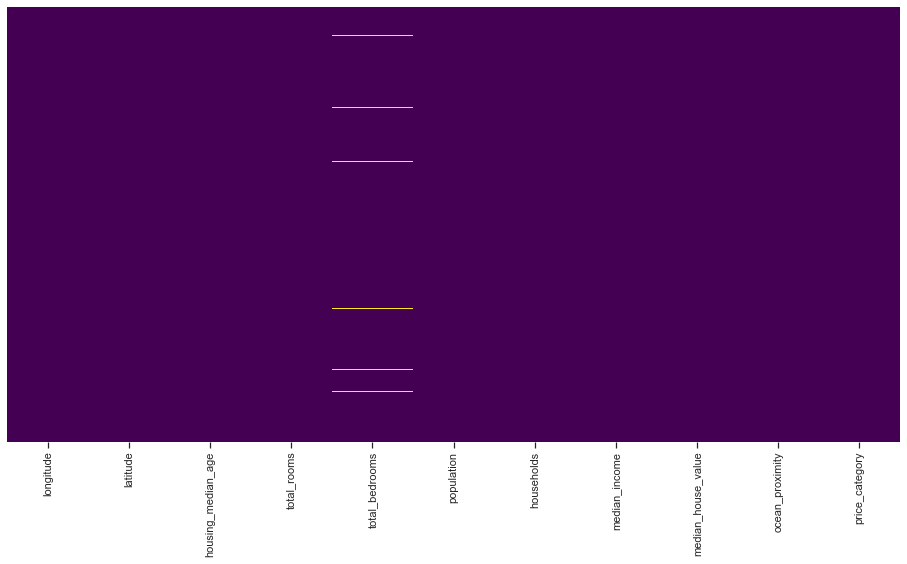

In [79]:
# show missing values (missing values - if present - will be displayed in yellow)
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [80]:
print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
price_category          0
dtype: int64


There are 207 lines where we do not have a value for the amount of total bedrooms!

### Data Transformation & Tidying data
What was learned from the data Inscpetion:
- First line (line 0) has to wrong values (housing median age: 41years and median_house_value). I will manually adjust these data, so that it will be correct, instead of dropping the whole line. Afterwards the data type can be changed to float64 (int64 would also be possible, but it might be possible, that there might decimal places)
- There are 207 lines where we do not have a value for the amount of total bedrooms!

In [81]:
# replace the data in line 0
df['housing_median_age'] = df['housing_median_age'].replace(['41.0years'], '41.0')
df['median_house_value'] = df['median_house_value'].replace(['452600.0$'], '452600.0')

# change data type
df['housing_median_age'] = pd.Float64Index(df['housing_median_age'])
df['median_house_value'] = pd.Float64Index(df['median_house_value'])
df['ocean_proximity'] =pd.Categorical(df['ocean_proximity'])
df['price_category'] =pd.Categorical(df['price_category'])

# check the data
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0          880           129.0   
1        -122.22     37.86                21.0         7099          1106.0   
2        -122.24     37.85                52.0         1467           190.0   
3        -122.25     37.85                52.0         1274           235.0   
4        -122.25     37.85                52.0         1627           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0         1665           374.0   
20636    -121.21     39.49                18.0          697           150.0   
20637    -121.22     39.43                17.0         2254           485.0   
20638    -121.32     39.43                18.0         1860           409.0   
20639    -121.24     39.37                16.0         2785           616.0   

       population  households  median_income  median_house_value  \
0             322         126         8.3252            452600.0   
1            2401        1138         8.3014            358500.0   
2             496         177         7.2574            352100.0   
3             558         219         5.6431            341300.0   
4             565         259         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635         845         330         1.5603             78100.0   
20636         356         114         2.5568             77100.0   
20637        1007         433         1.7000             92300.0   
20638         741         349         1.8672             84700.0   
20639        1387         530         2.3886             89400.0   

      ocean_proximity price_category  
0            NEAR BAY          above  
1            NEAR BAY          above  
2            NEAR BAY          above  
3            NEAR BAY          above  
4            NEAR BAY          above  
...               ...            ...  
20635          INLAND          above  
20636          INLAND          above  
20637          INLAND          above  
20638          INLAND          above  
20639          INLAND          above  

[20640 rows x 11 columns]

In [82]:
# check if the data types were changed succesfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  int64   
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  int64   
 6   households          20640 non-null  int64   
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
 10  price_category      20640 non-null  category
dtypes: category(2), float64(6), int64(3)
memory usage: 1.5 MB


In [83]:
# change column name, so that the naming is similar to the other colum names

df.rename(columns = {
    "housing_median_age": "median_housing_age"},
inplace=True)

df

longitude  latitude  median_housing_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0          880           129.0   
1        -122.22     37.86                21.0         7099          1106.0   
2        -122.24     37.85                52.0         1467           190.0   
3        -122.25     37.85                52.0         1274           235.0   
4        -122.25     37.85                52.0         1627           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0         1665           374.0   
20636    -121.21     39.49                18.0          697           150.0   
20637    -121.22     39.43                17.0         2254           485.0   
20638    -121.32     39.43                18.0         1860           409.0   
20639    -121.24     39.37                16.0         2785           616.0   

       population  households  median_income  median_house_value  \
0             322         126         8.3252            452600.0   
1            2401        1138         8.3014            358500.0   
2             496         177         7.2574            352100.0   
3             558         219         5.6431            341300.0   
4             565         259         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635         845         330         1.5603             78100.0   
20636         356         114         2.5568             77100.0   
20637        1007         433         1.7000             92300.0   
20638         741         349         1.8672             84700.0   
20639        1387         530         2.3886             89400.0   

      ocean_proximity price_category  
0            NEAR BAY          above  
1            NEAR BAY          above  
2            NEAR BAY          above  
3            NEAR BAY          above  
4            NEAR BAY          above  
...               ...            ...  
20635          INLAND          above  
20636          INLAND          above  
20637          INLAND          above  
20638          INLAND          above  
20639          INLAND          above  

[20640 rows x 11 columns]

Dropping irrelevant features:
longitude, latitude wont affect the median_house_value. Moreover the price_category wont affect it neither since it is already based on the median_house_value. Also it may not be included since it is based on the median_house_value.

In [84]:
# Drop irrelevant features
df = df.drop(['longitude', 'latitude', 'price_category'], axis=1)


Adding new colums to the table.

Background: Total_rooms & total_bedrooms is not comparable if in one district are 100 households and in one 500 households --> calculation per household
Also for the avg. size per household to see how big the household and therefore the flat is (even though it is already included in the avg_rooms_per_household)

Afterwards the total_rooms and total_bedrooms can be dropped, because it is already included via the avg_per_household

In [85]:
# calculate average rooms per household: total_rooms/households
df['avg_rooms_per_household'] = round(df['total_rooms']/df['households'],2)
# calculate average bedrooms per households: total_bedromms/ househols
df['avg_bedrooms_per_household'] = round(df['total_bedrooms']/df['households'],2)
# calculate average household size: population/households
df['avg_size_per_household'] = round(df['population']/df['households'],2)

# get the median income in $ and not in 10.000$
df['median_income']= df['median_income']*10000

df = df.drop(['total_rooms', 'total_bedrooms'], axis=1)

df

median_housing_age  population  households  median_income  \
0                    41.0         322         126        83252.0   
1                    21.0        2401        1138        83014.0   
2                    52.0         496         177        72574.0   
3                    52.0         558         219        56431.0   
4                    52.0         565         259        38462.0   
...                   ...         ...         ...            ...   
20635                25.0         845         330        15603.0   
20636                18.0         356         114        25568.0   
20637                17.0        1007         433        17000.0   
20638                18.0         741         349        18672.0   
20639                16.0        1387         530        23886.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
0                452600.0        NEAR BAY                     6.98   
1                358500.0        NEAR BAY                     6.24   
2                352100.0        NEAR BAY                     8.29   
3                341300.0        NEAR BAY                     5.82   
4                342200.0        NEAR BAY                     6.28   
...                   ...             ...                      ...   
20635             78100.0          INLAND                     5.05   
20636             77100.0          INLAND                     6.11   
20637             92300.0          INLAND                     5.21   
20638             84700.0          INLAND                     5.33   
20639             89400.0          INLAND                     5.25   

       avg_bedrooms_per_household  avg_size_per_household  
0                            1.02                    2.56  
1                            0.97                    2.11  
2                            1.07                    2.80  
3                            1.07                    2.55  
4                            1.08                    2.18  
...                           ...                     ...  
20635                        1.13                    2.56  
20636                        1.32                    3.12  
20637                        1.12                    2.33  
20638                        1.17                    2.12  
20639                        1.16                    2.62  

[20640 rows x 9 columns]

Therefore the empy lines will be filled with the Mean manually. --> **Update after Rücksprache: First split the data and afterwards add the median to the missing values, but in this case it is possible to drop these lines. Already existing code will be changed to comments**

In [86]:
mean_bedrooms_per_household = df['avg_bedrooms_per_household'].mean()
mean_bedrooms_per_household
# replace the empty lines

# df["avg_bedrooms_per_household"].fillna(mean_bedrooms_per_household, inplace=True)

# instead of adding there the median these lines will be dropped
# drop rows with missing values

# drop remaining rows with one missing value
df = df.dropna()


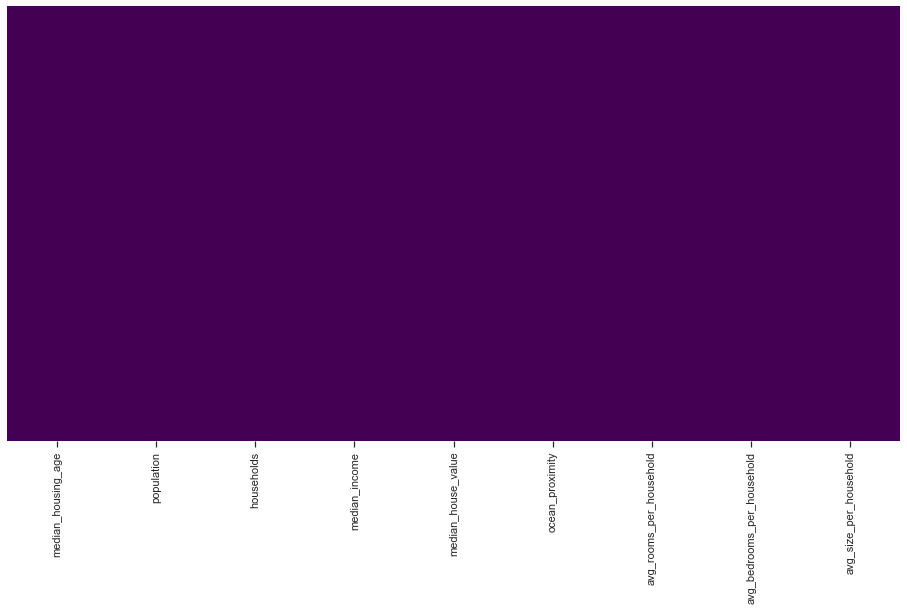

In [87]:
# show missing values --> empty lines were sucessfully exchanged with mean --> Update: These lines were dropped
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [88]:
# check column-wise distribution of null values
print(df.isnull().sum())

median_housing_age            0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
avg_rooms_per_household       0
avg_bedrooms_per_household    0
avg_size_per_household        0
dtype: int64


In [89]:
#summary statistics for all numerical colums (in transposed view)
round(df.describe(),2).T

count       mean        std       min  \
median_housing_age          20433.0      28.63      12.59      1.00   
population                  20433.0    1424.95    1133.21      3.00   
households                  20433.0     499.43     382.30      1.00   
median_income               20433.0   38711.62   18992.91   4999.00   
median_house_value          20433.0  206864.41  115435.67  14999.00   
avg_rooms_per_household     20433.0       5.43       2.48      0.85   
avg_bedrooms_per_household  20433.0       1.10       0.48      0.33   
avg_size_per_household      20433.0       3.07      10.44      0.69   

                                  25%        50%        75%        max  
median_housing_age              18.00      29.00      37.00      52.00  
population                     787.00    1166.00    1722.00   35682.00  
households                     280.00     409.00     604.00    6082.00  
median_income                25637.00   35365.00   47440.00  150001.00  
median_house_value          119500.00  179700.00  264700.00  500001.00  
avg_rooms_per_household          4.44       5.23       6.05     141.91  
avg_bedrooms_per_household       1.01       1.05       1.10      34.07  
avg_size_per_household           2.43       2.82       3.28    1243.33

These values show that there a some data errors, it can be seen at the max value of avg_rooms_per_household, avg_bedrooms_per_household & avg_size_per_household. For avg rooms and bedrooms it might be possible (with very small chance) that there are only giant villas. Therefore I assume it is a data error. 
Moreover there wont be a houshold in which more than 1.200 people are living

Furthermore it can be seen, that avg_bedrooms_per_household wont bring any benefit to the data model regression, because 75% of these values are between 1.01 and 1.10. This minor changes wont affect the median housing price.




In [90]:
df = df.drop(['avg_bedrooms_per_household'], axis=1)

In [91]:
#calculate the mean --> not needed, change to comment
df["median_house_value"].mean()

206864.41315519012

In [92]:
#add the mean (we call it "average") to our DataFrame --> not needed, change to comment
# df = df.assign(average_house_value = (df["median_house_value"].mean()))

df.head(5)


median_housing_age  population  households  median_income  \
0                41.0         322         126        83252.0   
1                21.0        2401        1138        83014.0   
2                52.0         496         177        72574.0   
3                52.0         558         219        56431.0   
4                52.0         565         259        38462.0   

   median_house_value ocean_proximity  avg_rooms_per_household  \
0            452600.0        NEAR BAY                     6.98   
1            358500.0        NEAR BAY                     6.24   
2            352100.0        NEAR BAY                     8.29   
3            341300.0        NEAR BAY                     5.82   
4            342200.0        NEAR BAY                     6.28   

   avg_size_per_household  
0                    2.56  
1                    2.11  
2                    2.80  
3                    2.55  
4                    2.18

In [93]:
#summary statistics for all categorical colums 
df.describe(include=['category'])

ocean_proximity
count            20433
unique               5
top          <1H OCEAN
freq              9034

In [94]:
# show the 5 different data types in ocean_proximity
df.ocean_proximity.value_counts().index

CategoricalIndex(['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'], categories=['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], ordered=False, dtype='category')

Ill try to change these values in numerical data columns via One Hot encoding, there might be a better solution, but I could not find any (which I can understand).
Also I am not sure how to handle this 5 variables, has near bay or island the higher value?
Thererfore Ill create 5 more columns for each unique variable in the ocean_proximity.

**Update** dummies will be created in later steps and NOT added to the dataframe, this is important for the Lasso regression


In [95]:
# dummies = pd.get_dummies(df['ocean_proximity'])

In [96]:
# dummies.info()

In [97]:
# print(dummies.head())

In [98]:
# df = pd.concat([df.drop('ocean_proximity', axis=1), pd.get_dummies(df['ocean_proximity'])], axis=1)

In [99]:
df

median_housing_age  population  households  median_income  \
0                    41.0         322         126        83252.0   
1                    21.0        2401        1138        83014.0   
2                    52.0         496         177        72574.0   
3                    52.0         558         219        56431.0   
4                    52.0         565         259        38462.0   
...                   ...         ...         ...            ...   
20635                25.0         845         330        15603.0   
20636                18.0         356         114        25568.0   
20637                17.0        1007         433        17000.0   
20638                18.0         741         349        18672.0   
20639                16.0        1387         530        23886.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
0                452600.0        NEAR BAY                     6.98   
1                358500.0        NEAR BAY                     6.24   
2                352100.0        NEAR BAY                     8.29   
3                341300.0        NEAR BAY                     5.82   
4                342200.0        NEAR BAY                     6.28   
...                   ...             ...                      ...   
20635             78100.0          INLAND                     5.05   
20636             77100.0          INLAND                     6.11   
20637             92300.0          INLAND                     5.21   
20638             84700.0          INLAND                     5.33   
20639             89400.0          INLAND                     5.25   

       avg_size_per_household  
0                        2.56  
1                        2.11  
2                        2.80  
3                        2.55  
4                        2.18  
...                       ...  
20635                    2.56  
20636                    3.12  
20637                    2.33  
20638                    2.12  
20639                    2.62  

[20433 rows x 8 columns]

#### Searching for data errors/outliners and removing them 
This will be done before the data set will be splitted (Feedback from Rücksprache on 22.12)

Analyse each column with boxplot charts to see if there are outliners in the data

<AxesSubplot:xlabel='median_housing_age'>

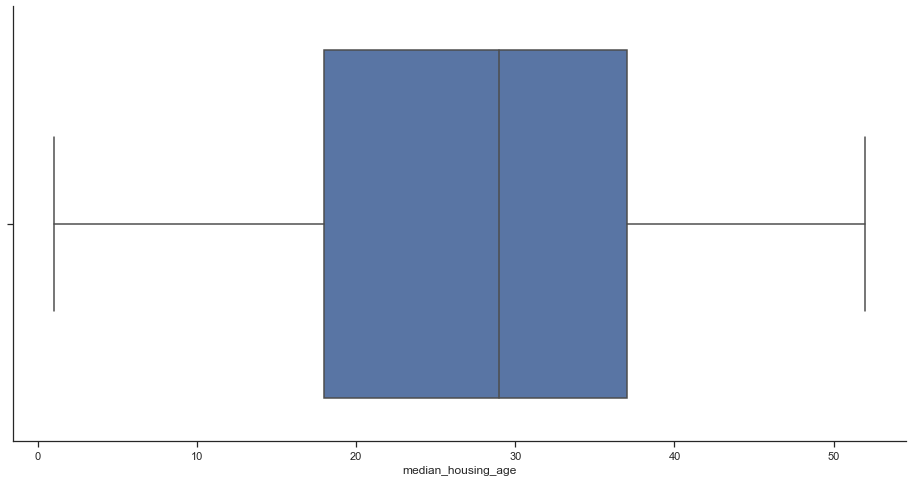

In [100]:
sns.boxplot(x='median_housing_age', data=df)

**Median_housing_Age** dows not have any data errors or outliners

<AxesSubplot:xlabel='population'>

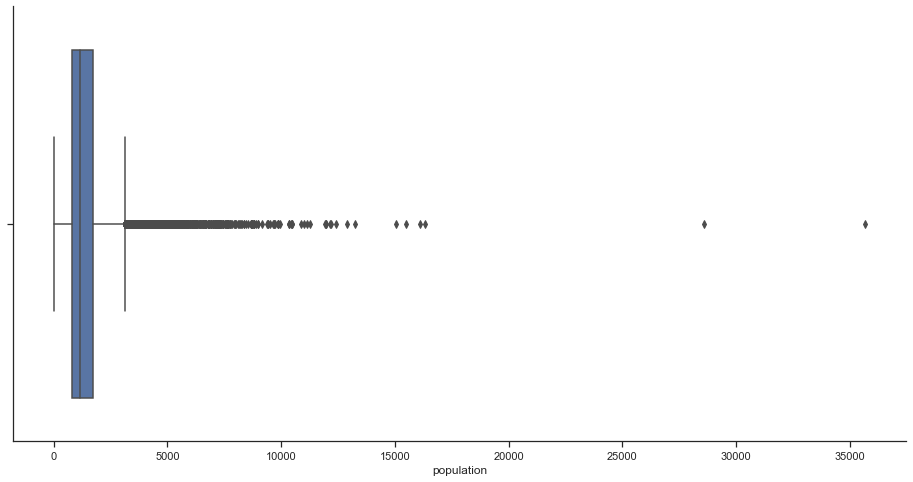

In [101]:
sns.boxplot(x='population', data=df)

Seems like there are some outliers/data errors for the **population** this shall be checked with Cooks distance

<AxesSubplot:xlabel='households'>

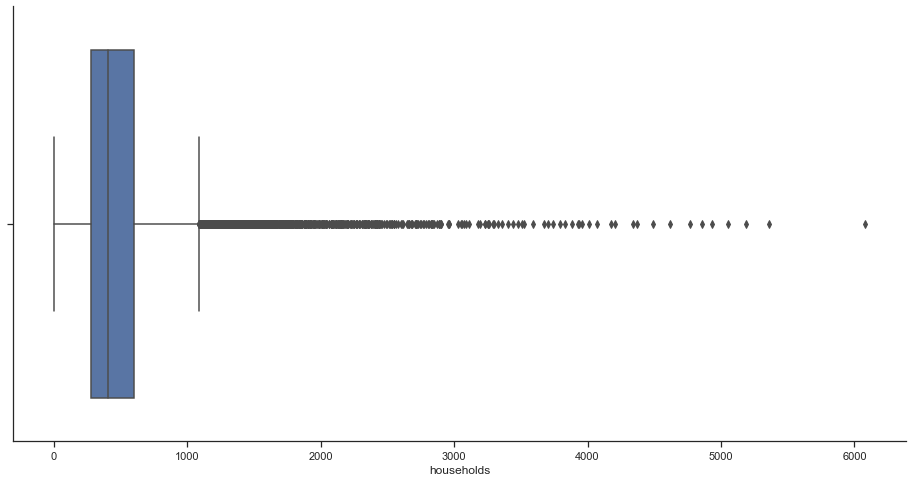

In [102]:
sns.boxplot(x='households', data=df)

Seems like there are some outliers/data errors for the **households** this shall be checked with Cooks distance

<AxesSubplot:xlabel='median_income'>

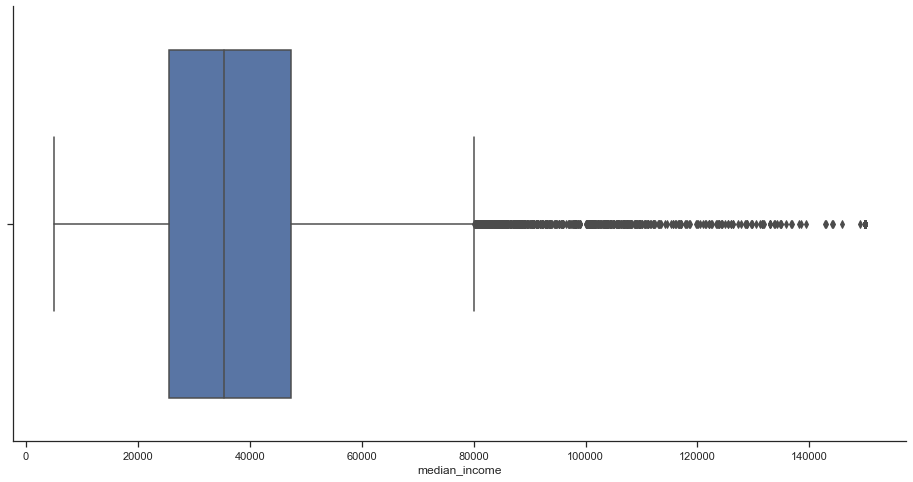

In [103]:
sns.boxplot(x='median_income', data=df)

Seems like there are some outliers/data errors for the **median_income** this shall be checked with Cooks distance

<AxesSubplot:xlabel='avg_rooms_per_household'>

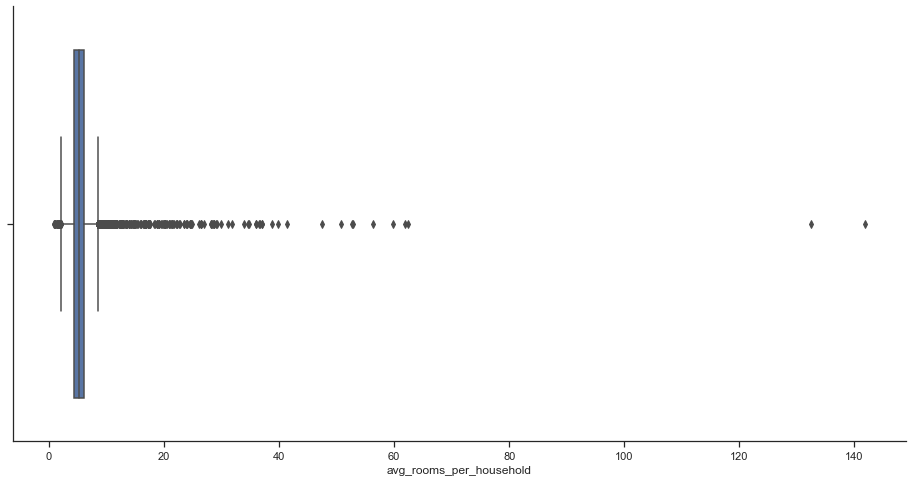

In [104]:
sns.boxplot(x='avg_rooms_per_household', data=df)

Seems like there are some outliers/data errors for the **avg_rooms_per_household** this shall be checked with Cooks distance

<AxesSubplot:xlabel='avg_size_per_household'>

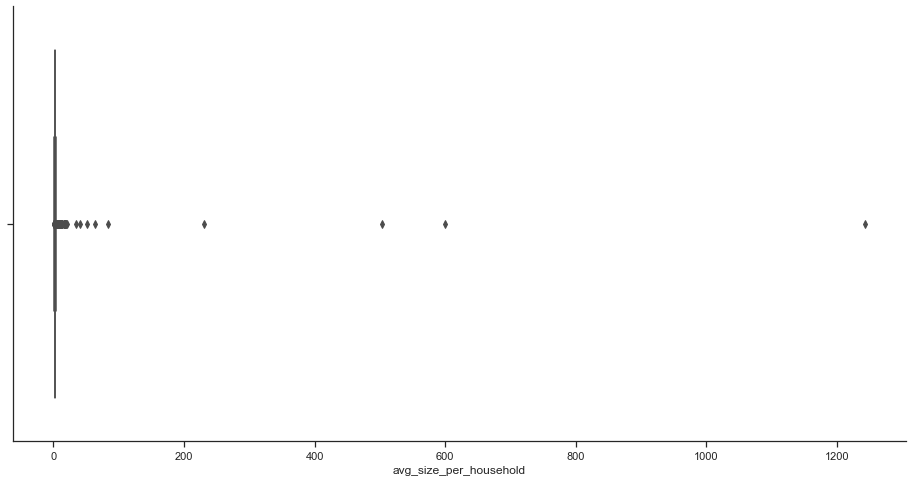

In [105]:
sns.boxplot(x='avg_size_per_household', data=df)

Seems like there are some outliers/data errors for the **avg_size_per_household** this shall be checked with Cooks distance

<AxesSubplot:xlabel='median_house_value'>

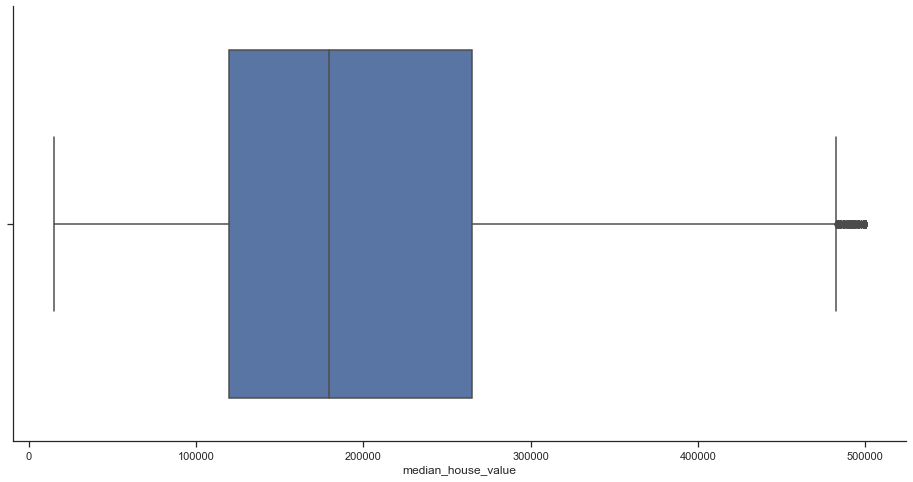

In [106]:
sns.boxplot(x='median_house_value', data=df)

Seems like there are some outliers/data errors for the **median_house_value** this shall be checked with Cooks distance

#### Cooks distance
First we need to create a model with all parameters so that the Cooks dinstance cann be calculated

In [107]:
df

median_housing_age  population  households  median_income  \
0                    41.0         322         126        83252.0   
1                    21.0        2401        1138        83014.0   
2                    52.0         496         177        72574.0   
3                    52.0         558         219        56431.0   
4                    52.0         565         259        38462.0   
...                   ...         ...         ...            ...   
20635                25.0         845         330        15603.0   
20636                18.0         356         114        25568.0   
20637                17.0        1007         433        17000.0   
20638                18.0         741         349        18672.0   
20639                16.0        1387         530        23886.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
0                452600.0        NEAR BAY                     6.98   
1                358500.0        NEAR BAY                     6.24   
2                352100.0        NEAR BAY                     8.29   
3                341300.0        NEAR BAY                     5.82   
4                342200.0        NEAR BAY                     6.28   
...                   ...             ...                      ...   
20635             78100.0          INLAND                     5.05   
20636             77100.0          INLAND                     6.11   
20637             92300.0          INLAND                     5.21   
20638             84700.0          INLAND                     5.33   
20639             89400.0          INLAND                     5.25   

       avg_size_per_household  
0                        2.56  
1                        2.11  
2                        2.80  
3                        2.55  
4                        2.18  
...                       ...  
20635                    2.56  
20636                    3.12  
20637                    2.33  
20638                    2.12  
20639                    2.62  

[20433 rows x 8 columns]

In [108]:
# create model with all parameters and save it as lm_cook, only numerical data will be used, due to the fact that I am looking for outliners
lm_cook = ols("median_house_value ~ median_housing_age + population + households + median_income + avg_rooms_per_household + avg_size_per_household", data=df).fit()

In [109]:
# print regression results
print(lm_cook.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4271.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:27:00   Log-Likelihood:            -2.5886e+05
No. Observations:               20433   AIC:                         5.177e+05
Df Residuals:                   20426   BIC:                         5.178e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2

We can see from the p-value of avg_size_per_household that this parameter has no effects on our model as it is higher than 5%. Therefore this column could be dropped. But first lets have a look on the detailed plots (the removal of errors)

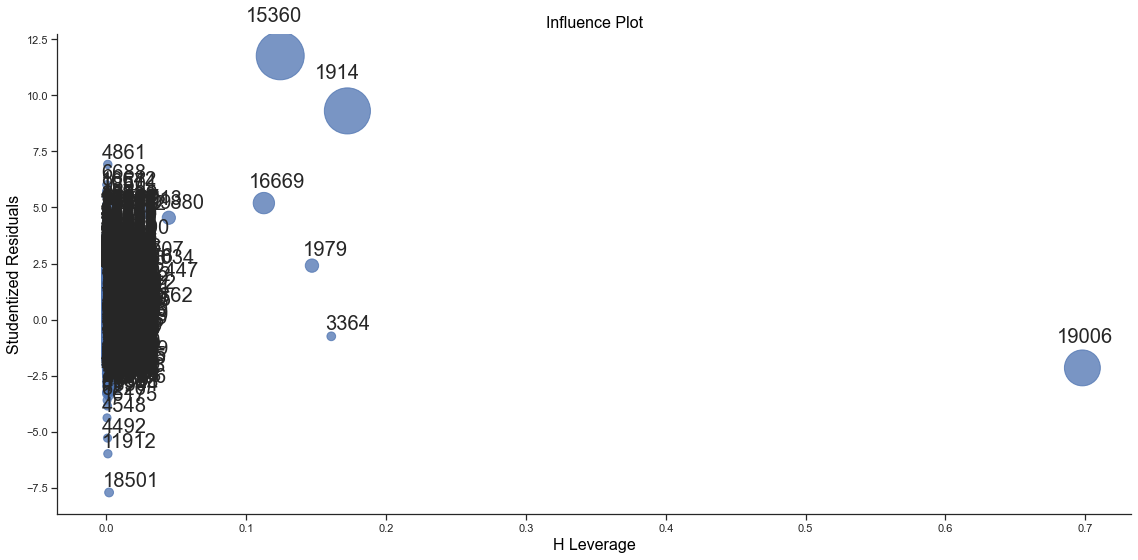

In [110]:
# Create an Influence Plot
fig = sm.graphics.influence_plot(lm_cook, criterion="cooks")
fig.tight_layout(pad=1.0)

To identify values with high influence, we look for observations with:

- big blue points (high Cook’s distance) and

- high leverage (X-axis) which additionally have

- high or low studentized residuals (Y-axis).

--> Outliners will be analyzed via Cooks distance

In [111]:
# obtains Cook's distance
fit_cooksd = lm_cook.get_influence().cooks_distance[0]

# get lenght of df to obtain n

n = len(df["median_housing_age"])

# calculate critical d
critical_d =4/n
print('Critical Cooks distance', critical_d)

# identification of potential outliers with Levarage
out_d = fit_cooksd > critical_d

# output potential outliers with levarage
print(df.index[out_d], "\n",
        fit_cooksd[out_d])




Critical Cooks distance 0.0001957617579405863
Int64Index([   61,    89,    95,   131,   395,   409,   457,   458,   459,
              460,
            ...
            20326, 20328, 20335, 20336, 20349, 20367, 20443, 20447, 20527,
            20544],
           dtype='int64', length=854) 
 [4.71212956e-04 1.07817157e-03 3.21094057e-03 3.20396586e-04
 2.13166505e-04 2.74493938e-04 4.61357513e-04 6.44901532e-04
 1.48043321e-03 6.21300257e-04 4.37862921e-04 2.34127202e-03
 7.02034472e-04 3.58656345e-04 3.99830978e-04 3.26240855e-04
 2.22896519e-04 1.98782920e-04 2.31951299e-04 6.38349418e-04
 2.27206419e-04 9.66811005e-04 2.64745826e-04 9.79105984e-04
 5.07249975e-04 1.96740592e-04 3.97496956e-04 2.97145105e-04
 2.48295613e-04 7.93857582e-04 4.14160027e-04 3.34677558e-04
 2.73633357e-04 1.24914048e-03 4.66233198e-03 3.17617964e-04
 6.08923858e-04 2.97546990e-04 7.49267555e-04 1.98214883e-04
 1.24544804e-03 4.57111064e-03 1.24588791e-03 4.28239340e-03
 9.53797859e-02 2.56762366e+00 3.70025

In [112]:
# drop the data which is identified as outliners by the cooks distance
df.drop(df.index[out_d], axis=0, inplace=True)

df

median_housing_age  population  households  median_income  \
0                    41.0         322         126        83252.0   
1                    21.0        2401        1138        83014.0   
2                    52.0         496         177        72574.0   
3                    52.0         558         219        56431.0   
4                    52.0         565         259        38462.0   
...                   ...         ...         ...            ...   
20635                25.0         845         330        15603.0   
20636                18.0         356         114        25568.0   
20637                17.0        1007         433        17000.0   
20638                18.0         741         349        18672.0   
20639                16.0        1387         530        23886.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
0                452600.0        NEAR BAY                     6.98   
1                358500.0        NEAR BAY                     6.24   
2                352100.0        NEAR BAY                     8.29   
3                341300.0        NEAR BAY                     5.82   
4                342200.0        NEAR BAY                     6.28   
...                   ...             ...                      ...   
20635             78100.0          INLAND                     5.05   
20636             77100.0          INLAND                     6.11   
20637             92300.0          INLAND                     5.21   
20638             84700.0          INLAND                     5.33   
20639             89400.0          INLAND                     5.25   

       avg_size_per_household  
0                        2.56  
1                        2.11  
2                        2.80  
3                        2.55  
4                        2.18  
...                       ...  
20635                    2.56  
20636                    3.12  
20637                    2.33  
20638                    2.12  
20639                    2.62  

[19579 rows x 8 columns]

Tidying up data was successfully made!

There were a lot of outliners in the data set. Before the outliners were removed, the data set contained 20433 rows and now only 19579.

Therefore there were **854** rows which were outliners 

--> this is a lot! Maybe I made somewhere a mistake...

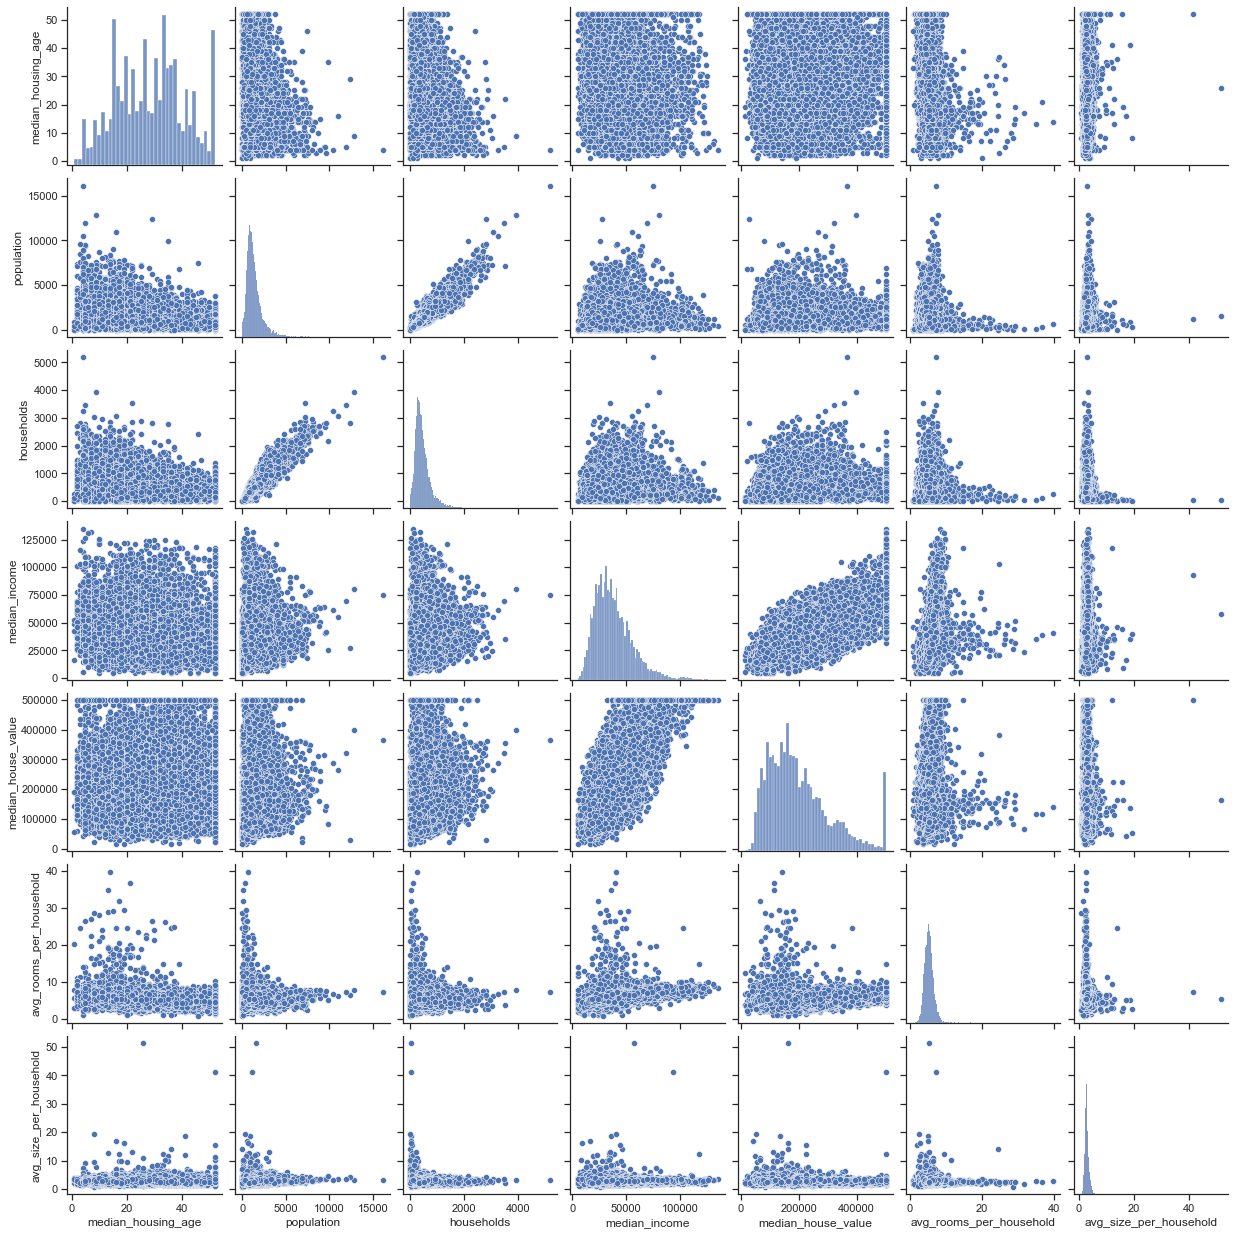

In [113]:
#historgram with seaborn
sns.pairplot(data=df);

It is hard to find the impact of each variable due to the huge amount of data. 

What can be seen: 

- Positive association between **median_house_value** and **median_income** which is linear
- There might be positive associations between **median_house_value** and **avg_rooms_per_household** as well as **median_house_value** and **population** as all as **median_house_value** and **households** --> It is hard so state this clearly

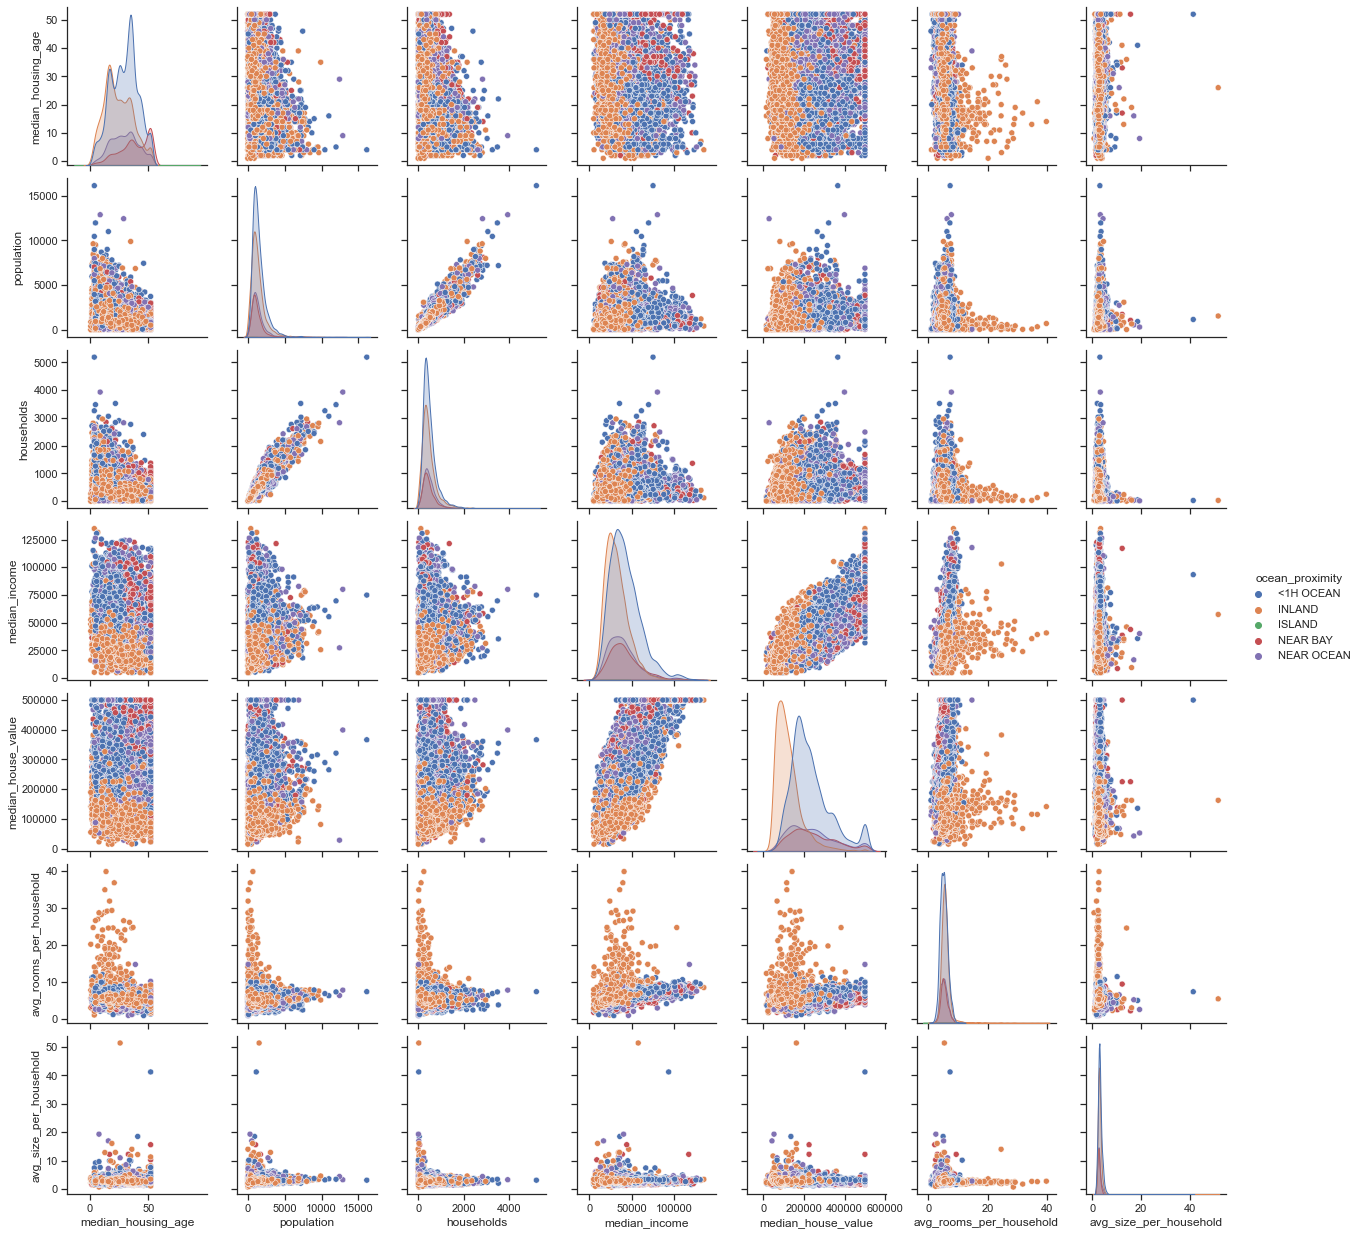

In [114]:
sns.pairplot(df, hue="ocean_proximity");

Impact of ocean proximity to median house value:
- Inland leads to a lower house value, all orange dots are more on the left side of the graphs with median_house_value. 
- <1H Ocean has some influence on the median_house_value. Blue dots are in the middle and on the right side of the graphs with median house value.
- Inland and <1H ocean are occuring way more often than the Island, Near Bay and Near Ocean
- For Island I can not see a difference between the median house value, because I can not really identify green dots
- Near Bay and Near Ocean may lead to a higher median house value (see later in detail)

In [115]:
df.describe().T

count           mean            std       min  \
median_housing_age       19579.0      28.625415      12.403796      1.00   
population               19579.0    1391.637264     971.547904      6.00   
households               19579.0     485.262424     330.861433      2.00   
median_income            19579.0   38253.234639   17664.128856   4999.00   
median_house_value       19579.0  199358.129782  107887.055048  14999.00   
avg_rooms_per_household  19579.0       5.363709       1.601195      0.85   
avg_size_per_household   19579.0       2.945464       0.918313      0.69   

                               25%        50%        75%        max  
median_housing_age           18.00      29.00      37.00      52.00  
population                  793.00    1166.00    1711.00   16122.00  
households                  281.00     408.00     594.00    5189.00  
median_income             25598.50   35272.00   47329.00  134883.00  
median_house_value       117600.00  175800.00  254500.00  500001.00  
avg_rooms_per_household       4.46       5.24       6.04      39.76  
avg_size_per_household        2.45       2.83       3.29      51.40

Now lets have a look on the influence of each variable to the median_house_value

<AxesSubplot:xlabel='median_housing_age', ylabel='median_house_value'>

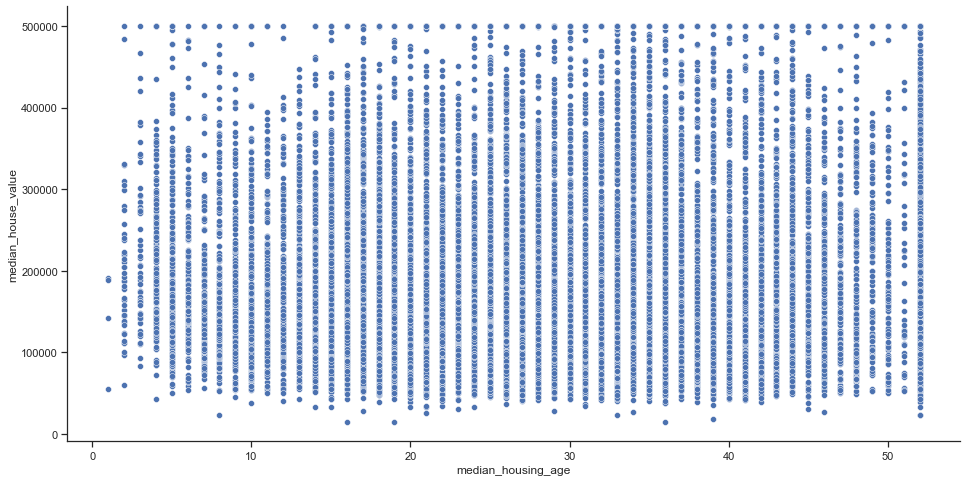

In [116]:
sns.scatterplot(data=df, x='median_housing_age', y='median_house_value')

This variable has no influence on the median_house_value. Atleast I cannot see that it affects it. So this variable wont be added to the model.

<AxesSubplot:xlabel='population', ylabel='median_house_value'>

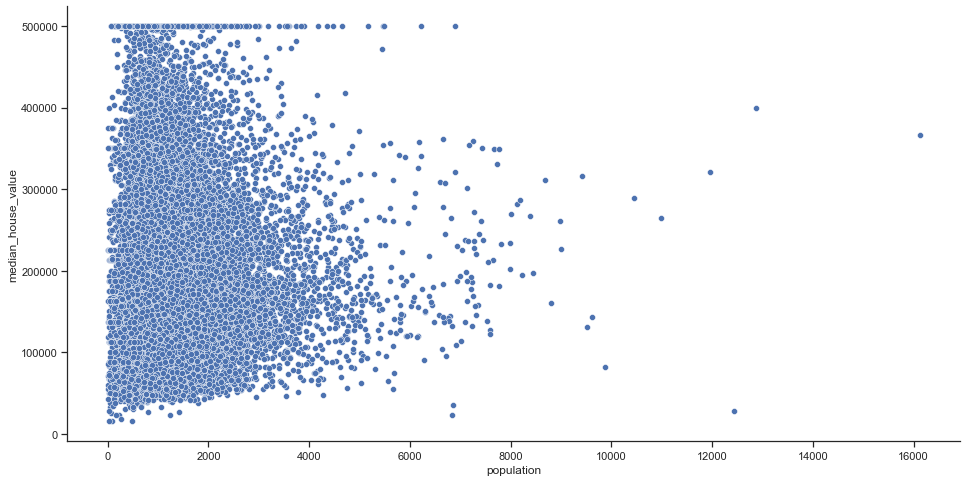

In [117]:
sns.scatterplot(data=df, x='population', y='median_house_value')

Only a very small influence for this variable can be seen for the median_house_value.

<AxesSubplot:xlabel='households', ylabel='median_house_value'>

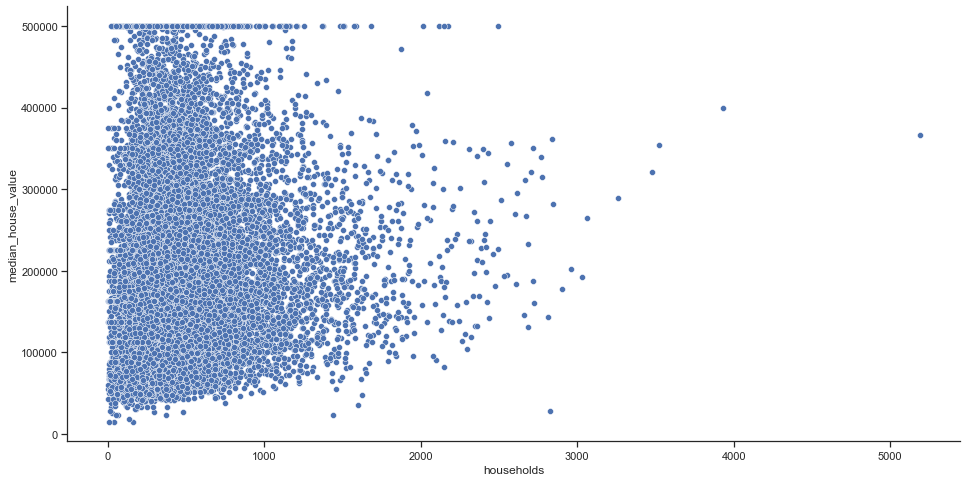

In [118]:
sns.scatterplot(data=df, x='households', y='median_house_value')

The influence is also very small, but a bit higher than for the population

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

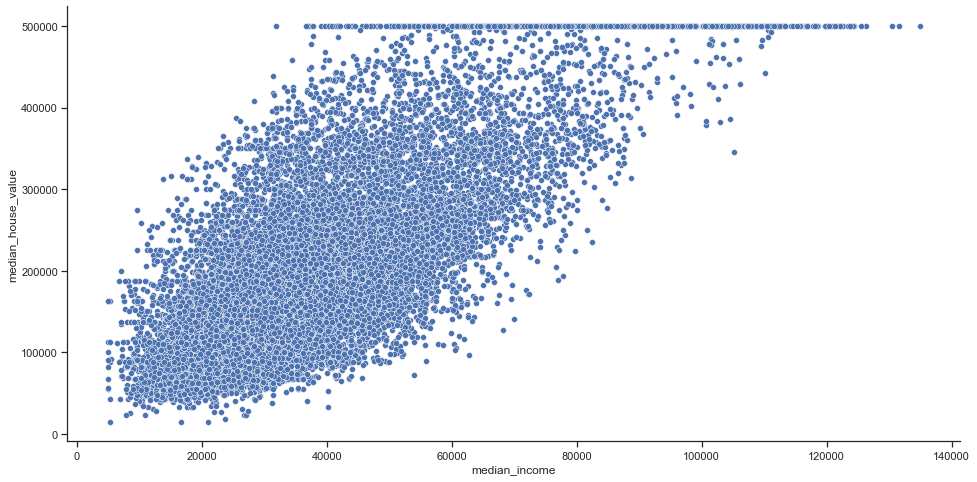

In [119]:
sns.scatterplot(data=df, x='median_income', y='median_house_value')

For this variable it can be seen that this variable has a strong influence on the median_house_value. A strong and positive association can be seen here. This variable will be added for sure to the model

<AxesSubplot:xlabel='avg_rooms_per_household', ylabel='median_house_value'>

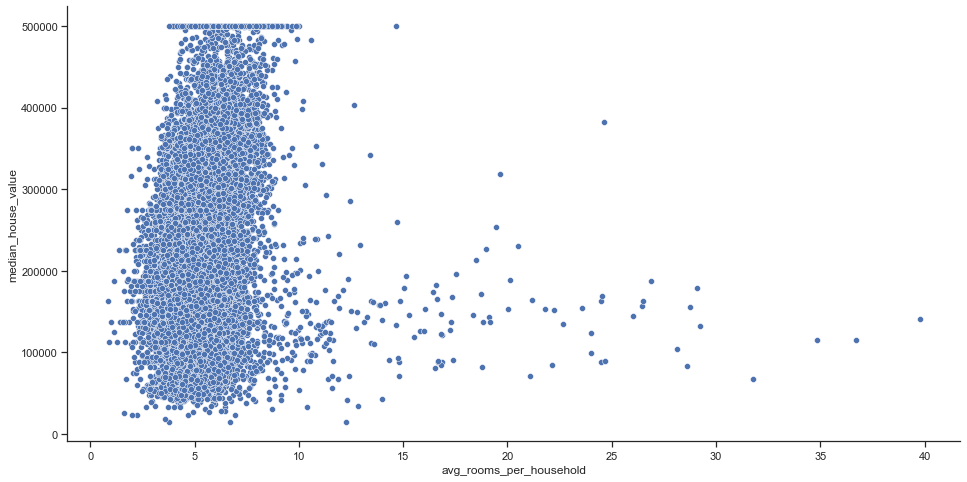

In [120]:
sns.scatterplot(data=df, x='avg_rooms_per_household', y='median_house_value')

I can not see a big influence of this variable to the median_house_value

<AxesSubplot:xlabel='avg_size_per_household', ylabel='median_house_value'>

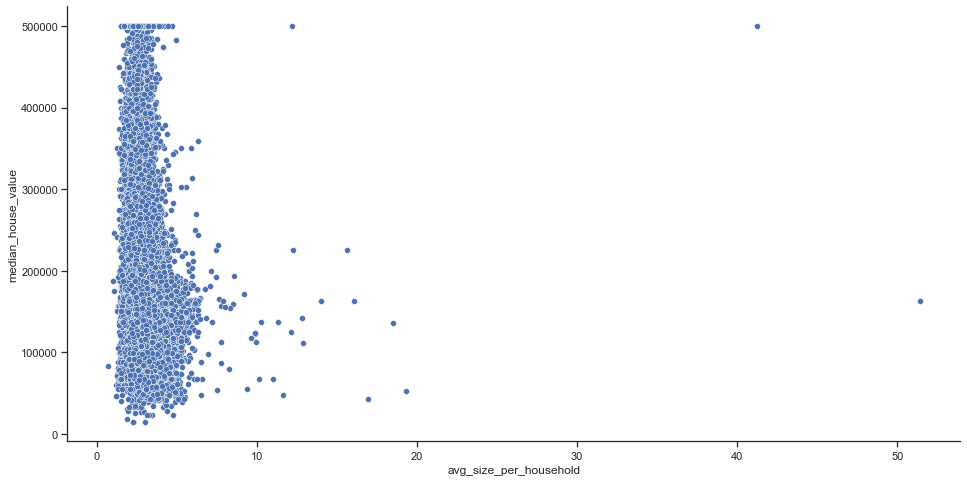

In [121]:
sns.scatterplot(data=df, x='avg_size_per_household', y='median_house_value')

I can not see a big influence for this variable on the median_house_value

Moreover: Some median_house_values are at 500.000 no matter of what each variable says... Are these data errors? For sure this has a big impact on the model and the results of the model. No matter what each variable says, it seems like some avalues are randomly at 500.000

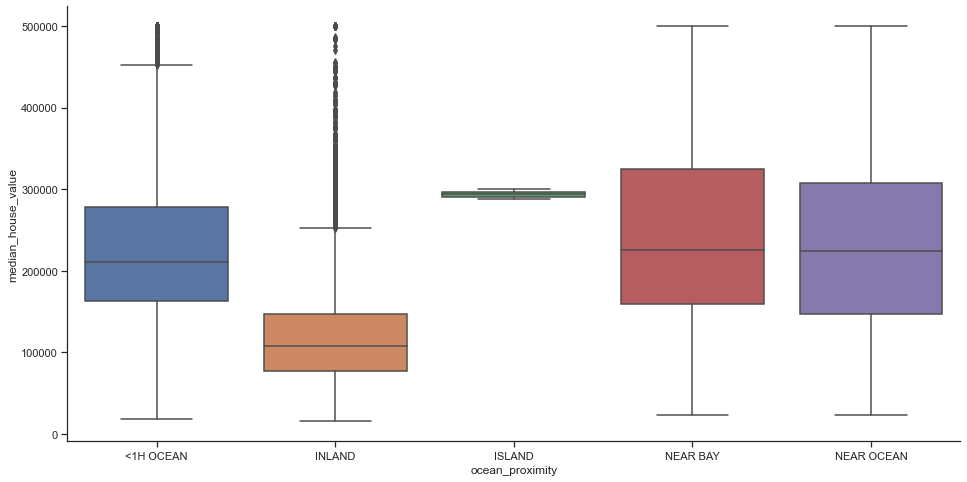

In [122]:
#boxplot
sns.boxplot(data=df, y="median_house_value", x="ocean_proximity");

There are some differences between the different values of the ocean_proximity. Mainly the Inland variable affects the median_house_value. This value reduces the price. The other variables (except ISLAND) do not have a big influence on the median_house_value.
For the ISLAND variable, we can see that this one increases the price of the median_house_value.
I will add the Ocean_proximity to the model, as we have an influence from this variable (mainly on INLAND)

## Correlation analysis

In [123]:
# Create correlation matrix for numerical variables
# Zusammenhang zwischen 2 Variablen, korrelationskoeffizient bewegt sich zwischen -1 und +1
corr_matrix = df.corr()
corr_matrix

median_housing_age  population  households  \
median_housing_age                 1.000000   -0.308183   -0.317670   
population                        -0.308183    1.000000    0.921790   
households                        -0.317670    0.921790    1.000000   
median_income                     -0.145890    0.024361    0.036074   
median_house_value                 0.089479   -0.010551    0.075767   
avg_rooms_per_household           -0.218036   -0.065992   -0.068740   
avg_size_per_household             0.011086    0.149189   -0.124106   

                         median_income  median_house_value  \
median_housing_age           -0.145890            0.089479   
population                    0.024361           -0.010551   
households                    0.036074            0.075767   
median_income                 1.000000            0.747953   
median_house_value            0.747953            1.000000   
avg_rooms_per_household       0.500303            0.249492   
avg_size_per_household       -0.056293           -0.201670   

                         avg_rooms_per_household  avg_size_per_household  
median_housing_age                     -0.218036                0.011086  
population                             -0.065992                0.149189  
households                             -0.068740               -0.124106  
median_income                           0.500303               -0.056293  
median_house_value                      0.249492               -0.201670  
avg_rooms_per_household                 1.000000               -0.053757  
avg_size_per_household                 -0.053757                1.000000

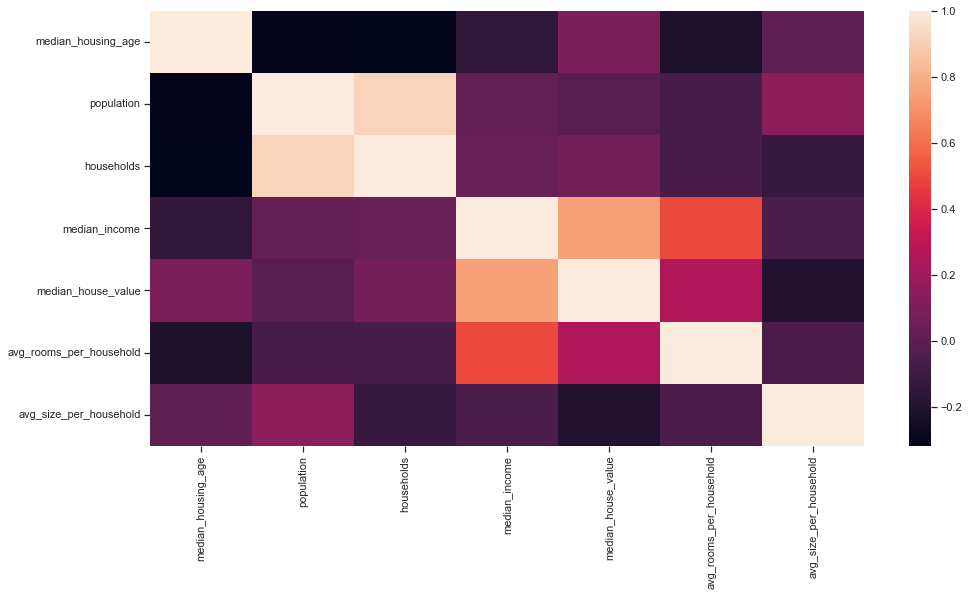

In [124]:
# Simple heatmap
heatmap = sns.heatmap(corr_matrix)

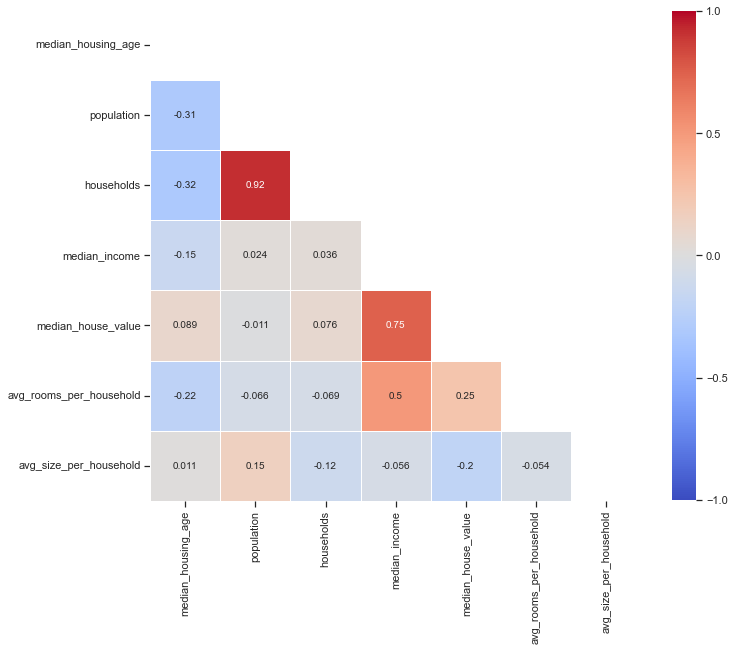

In [125]:
# Make a pretty heatmap

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Change size
plt.subplots(figsize=(11, 15))

# Build heatmap with additional options
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

Analysis of the heatmap:
- Households and population affect each other a lot (makes sense, if there are living more people then there will be more households)
- **Median income** have a big impact on our response variable **Median_house_value** and on the **avg_rooms_per_household**
- Only **Median income** affects our response variable **Median_house_value** a lot
- **avg_rooms_per_household** has also an effect in our **median_house_value**, but not as big as the median_income

> Note
> The categorical variable Ocean_proximity is not included here, As described in the plots above it also has an impact on our model

### VIF factor



In [126]:
y, X =dmatrices('median_house_value ~ median_housing_age + population + households + median_income + avg_rooms_per_household + avg_size_per_household', df, return_type='dataframe')

# For each X. calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["Feature"] = X.columns

vif.round(2)

VIF Factor                  Feature
0       54.86                Intercept
1        1.19       median_housing_age
2       12.58               population
3       12.62               households
4        1.34            median_income
5        1.42  avg_rooms_per_household
6        1.93   avg_size_per_household

We can see that population and households have a VIF factor which is above 5. This means that the collinarity is critical and the parameter predictions will have high standard errors. So only one of those should be added to the model. But at the end I will also add it to the model, just to see the impact of all variables to the model. This information will also be transferred to the classification notebook

Before I will start with the modelling process, I will do the regression basics to have a look on the available data. In this case I will create the average and compare predictions based on that to the real data.

# Regression Basics
## Mean


In [127]:
#calculate the mean
df["median_house_value"].mean()

199358.1297819092

In [128]:
#add the mean (I call it "average_house_price") to the DataFrame
# all added columns in this process will be dropped afterwards
df = df.assign(average_house_price = df["median_house_value"].mean())

df.head()

median_housing_age  population  households  median_income  \
0                41.0         322         126        83252.0   
1                21.0        2401        1138        83014.0   
2                52.0         496         177        72574.0   
3                52.0         558         219        56431.0   
4                52.0         565         259        38462.0   

   median_house_value ocean_proximity  avg_rooms_per_household  \
0            452600.0        NEAR BAY                     6.98   
1            358500.0        NEAR BAY                     6.24   
2            352100.0        NEAR BAY                     8.29   
3            341300.0        NEAR BAY                     5.82   
4            342200.0        NEAR BAY                     6.28   

   avg_size_per_household  average_house_price  
0                    2.56        199358.129782  
1                    2.11        199358.129782  
2                    2.80        199358.129782  
3                    2.55        199358.129782  
4                    2.18        199358.129782

## Regression Model

In this case I want to cover the descriptiv statistik to analyse 2 numeric variables (median_house_value and median_income) and 1 categorical (oncean_proximty) variable. Also some values are claculated manually instead of directly with the functions (even thought it is preferred with the functions)

In [129]:
# Regression model
# fit linear model with statsmodels.formula.api
lm_basic = smf.ols(formula ='median_house_value ~ median_income + ocean_proximity', data=df). fit()


#add the regression predictions (as "pred") to our DataFrame
df['pred'] = lm_basic.predict()

df.head(5)

median_housing_age  population  households  median_income  \
0                41.0         322         126        83252.0   
1                21.0        2401        1138        83014.0   
2                52.0         496         177        72574.0   
3                52.0         558         219        56431.0   
4                52.0         565         259        38462.0   

   median_house_value ocean_proximity  avg_rooms_per_household  \
0            452600.0        NEAR BAY                     6.98   
1            358500.0        NEAR BAY                     6.24   
2            352100.0        NEAR BAY                     8.29   
3            341300.0        NEAR BAY                     5.82   
4            342200.0        NEAR BAY                     6.28   

   avg_size_per_household  average_house_price           pred  
0                    2.56        199358.129782  416132.048417  
1                    2.11        199358.129782  415158.276059  
2                    2.80        199358.129782  372443.219673  
3                    2.55        199358.129782  306394.450015  
4                    2.18        199358.129782  232874.636970

On a first look on the data. The prediction is much better than the mean


In [130]:
# summary of regression results
lm_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     7602.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:04   Log-Likelihood:            -2.4412e+05
No. Observations:               19579   AIC:                         4.882e+05
Df Residuals:                   19573   BIC:                         4.883e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      6.102e+04   1293.059     47.190      0.000    5.85e+04    6.36e+04
ocean_proximity[T.INLAND]     -6.819e+04   1073.384    -63.529      0.000   -7.03e+04   -6.61e+04
ocean_proximity[T.ISLAND]      1.101e+05   4.45e+04      2.475      0.013    2.29e+04    1.97e+05
ocean_proximity[T.NEAR BAY]    1.449e+04   1529.706      9.471      0.000    1.15e+04    1.75e+04
ocean_proximity[T.NEAR OCEAN]  1.829e+04   1428.664     12.799      0.000    1.55e+04    2.11e+04
median_income                     4.0915      0.026    155.455      0.000       4.040       4.143
==============================================================================
Omnibus:                     2642.357   Durbin-Watson:                   0.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4354.034
Skew:                           0.924   Prob(JB):                         0.00
Kurtosis:                       4.385   Cond. No.                     4.17e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Mean

In [131]:
# calculate error (observation - average) and assign it to dataframe
df= df.assign(error = (df['median_house_value'] - df['average_house_price']))
df.head(5)

median_housing_age  population  households  median_income  \
0                41.0         322         126        83252.0   
1                21.0        2401        1138        83014.0   
2                52.0         496         177        72574.0   
3                52.0         558         219        56431.0   
4                52.0         565         259        38462.0   

   median_house_value ocean_proximity  avg_rooms_per_household  \
0            452600.0        NEAR BAY                     6.98   
1            358500.0        NEAR BAY                     6.24   
2            352100.0        NEAR BAY                     8.29   
3            341300.0        NEAR BAY                     5.82   
4            342200.0        NEAR BAY                     6.28   

   avg_size_per_household  average_house_price           pred          error  
0                    2.56        199358.129782  416132.048417  253241.870218  
1                    2.11        199358.129782  415158.276059  159141.870218  
2                    2.80        199358.129782  372443.219673  152741.870218  
3                    2.55        199358.129782  306394.450015  141941.870218  
4                    2.18        199358.129782  232874.636970  142841.870218

In [132]:
#calculate squard error and assign it to dataframe
df = df.assign(error_sq = (df['median_house_value'] - df['average_house_price'])**2)
df.head(5)

median_housing_age  population  households  median_income  \
0                41.0         322         126        83252.0   
1                21.0        2401        1138        83014.0   
2                52.0         496         177        72574.0   
3                52.0         558         219        56431.0   
4                52.0         565         259        38462.0   

   median_house_value ocean_proximity  avg_rooms_per_household  \
0            452600.0        NEAR BAY                     6.98   
1            358500.0        NEAR BAY                     6.24   
2            352100.0        NEAR BAY                     8.29   
3            341300.0        NEAR BAY                     5.82   
4            342200.0        NEAR BAY                     6.28   

   avg_size_per_household  average_house_price           pred          error  \
0                    2.56        199358.129782  416132.048417  253241.870218   
1                    2.11        199358.129782  415158.276059  159141.870218   
2                    2.80        199358.129782  372443.219673  152741.870218   
3                    2.55        199358.129782  306394.450015  141941.870218   
4                    2.18        199358.129782  232874.636970  142841.870218   

       error_sq  
0  6.413144e+10  
1  2.532613e+10  
2  2.333008e+10  
3  2.014749e+10  
4  2.040380e+10

In [133]:
# calcuate sum of squared error (total error of the mean)
TSS = df.error_sq.sum()
# print output
print('Total sum of squares (TSS) of average moodel:', TSS)

Total sum of squares (TSS) of average moodel: 227880414713987.25


In [134]:
# compare it to the SSR of the model:
SSR = lm_basic.ssr
print('Sum of squared residuals (SSR) of basic moodel:', SSR)

Sum of squared residuals (SSR) of basic moodel: 77461949044765.33


In [135]:
# explained sum of squares (SS_M = TSS - SS_R)
SSM = TSS - SSR
print (SSM)
# Explained sum of suqares (SS_M) fro statsmodel function
lm_basic.ess

150418465669221.94


150418465669221.94

Same values are calculated, therefore I made no mistakes. Next step is to calculate the R² manually

In [136]:
R_squared = SSM /TSS
print(R_squared)

# R_Squared of statsmodel
lm_basic.rsquared



0.6600763205473896


0.6600763205473896

In [137]:
# Adjusted R_Squared:
lm_basic.rsquared_adj

0.6599894857036118

Values are the same as from the Model summary.

Now lets calculate the correlation coefficient

In [138]:
# correlation coefficient r
r= np.sqrt(R_squared)
print (r)

0.8124508111555983


The value of the Pearsons's correlation effect is very high with 0.81, therefore this model fits quite good with the data

Now lets calculate the variance and standard deviation

In [139]:
# calculate variance of the model mean
# Number of observations (lenght of DataFrame)
n = len(df["median_house_value"])
# calculate
variance = (TSS/(n-1))
# print output
print('variance of the mean:', variance)

variance of the mean: 11639616646.950008


In [140]:
# obtain the standard deviation
print(f'Standard deviation (SD) of the mean= {round(np.sqrt(variance),2)}')

Standard deviation (SD) of the mean= 107887.06


The standard deviation of the average is high, this means that a lot of data points are far away from the average. It is more than 50% of the average

Now lets calculate the standard error

In [141]:
# calculate the standard error (our sample is more than 30)
se = df['median_house_value'].sem()
print(se)

771.0349869282661


The standard error is small compared to the sample mean. Therefore the data indicates that most sample means are similar to the population mean (i.e., our sample mean is likely to accurately reflect the population mean).

The next step is to calculate the z-scores

In [142]:
# calculate z-scores
z = stats.zscore(df.median_house_value)
print(z)
#assign z-scores to df
df = df.assign(z=z)

0        2.347347
1        1.475116
2        1.415793
3        1.315686
4        1.324028
           ...   
20635   -1.123965
20636   -1.133234
20637   -0.992342
20638   -1.062788
20639   -1.019223
Name: median_house_value, Length: 19579, dtype: float64


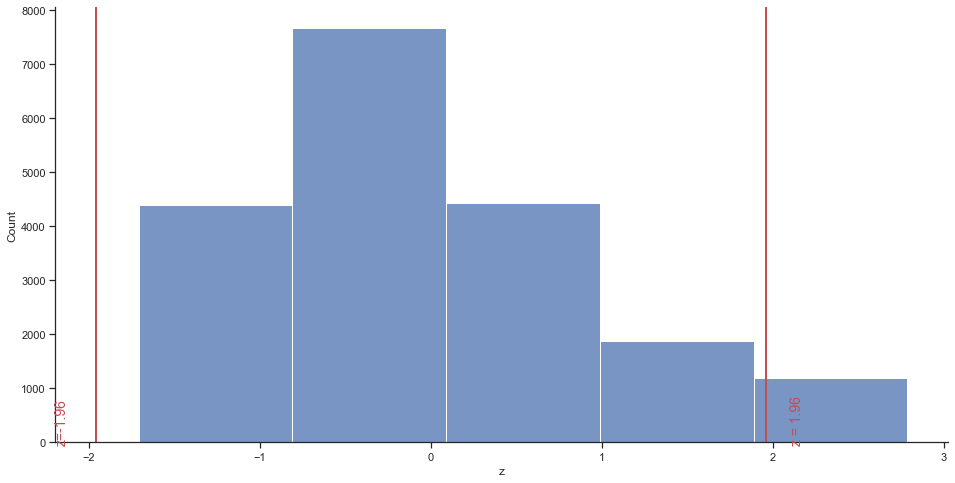

In [143]:
plt = sns.histplot(x="z", data =df, bins=5)

# draw a vertical line
plt.axvline(1.96, 0, 1, linewidth=2, color='r');

# add text
plt.text(2.1, 0.3, 'z = 1.96', rotation=90, color='r');
plt.axvline(-1.96, 0, 1, linewidth=2, color='r');
plt.text(-2.2, 0.3, 'z=-1.96', rotation=90, color='r');

This graph shows the 95% confidence intervall.

All data is above the lower confidence intervall, only the higher confidence intervall is exceeded


In [144]:
# lower boundary
lb = (df.median_house_value.mean() - (1.96*se))
# upper boundary
up = (df.median_house_value.mean() + (1.96*se))
print('Lower boundary of CI', lb)
print("upper boundary of CI", up)

Lower boundary of CI 197846.9012075298
upper boundary of CI 200869.3583562886


drop the added columns


In [145]:
df

median_housing_age  population  households  median_income  \
0                    41.0         322         126        83252.0   
1                    21.0        2401        1138        83014.0   
2                    52.0         496         177        72574.0   
3                    52.0         558         219        56431.0   
4                    52.0         565         259        38462.0   
...                   ...         ...         ...            ...   
20635                25.0         845         330        15603.0   
20636                18.0         356         114        25568.0   
20637                17.0        1007         433        17000.0   
20638                18.0         741         349        18672.0   
20639                16.0        1387         530        23886.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
0                452600.0        NEAR BAY                     6.98   
1                358500.0        NEAR BAY                     6.24   
2                352100.0        NEAR BAY                     8.29   
3                341300.0        NEAR BAY                     5.82   
4                342200.0        NEAR BAY                     6.28   
...                   ...             ...                      ...   
20635             78100.0          INLAND                     5.05   
20636             77100.0          INLAND                     6.11   
20637             92300.0          INLAND                     5.21   
20638             84700.0          INLAND                     5.33   
20639             89400.0          INLAND                     5.25   

       avg_size_per_household  average_house_price           pred  \
0                        2.56        199358.129782  416132.048417   
1                        2.11        199358.129782  415158.276059   
2                        2.80        199358.129782  372443.219673   
3                        2.55        199358.129782  306394.450015   
4                        2.18        199358.129782  232874.636970   
...                       ...                  ...            ...   
20635                    2.56        199358.129782   56668.482775   
20636                    3.12        199358.129782   97440.085925   
20637                    2.33        199358.129782   62384.281029   
20638                    2.12        199358.129782   69225.236420   
20639                    2.62        199358.129782   90558.215730   

               error      error_sq         z  
0      253241.870218  6.413144e+10  2.347347  
1      159141.870218  2.532613e+10  1.475116  
2      152741.870218  2.333008e+10  1.415793  
3      141941.870218  2.014749e+10  1.315686  
4      142841.870218  2.040380e+10  1.324028  
...              ...           ...       ...  
20635 -121258.129782  1.470353e+10 -1.123965  
20636 -122258.129782  1.494705e+10 -1.133234  
20637 -107058.129782  1.146144e+10 -0.992342  
20638 -114658.129782  1.314649e+10 -1.062788  
20639 -109958.129782  1.209079e+10 -1.019223  

[19579 rows x 13 columns]

In [146]:
# Drop irrelevant features
df = df.drop(['average_house_price', 'pred', 'error', 'error_sq', 'z'], axis=1)

In [147]:
df

median_housing_age  population  households  median_income  \
0                    41.0         322         126        83252.0   
1                    21.0        2401        1138        83014.0   
2                    52.0         496         177        72574.0   
3                    52.0         558         219        56431.0   
4                    52.0         565         259        38462.0   
...                   ...         ...         ...            ...   
20635                25.0         845         330        15603.0   
20636                18.0         356         114        25568.0   
20637                17.0        1007         433        17000.0   
20638                18.0         741         349        18672.0   
20639                16.0        1387         530        23886.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
0                452600.0        NEAR BAY                     6.98   
1                358500.0        NEAR BAY                     6.24   
2                352100.0        NEAR BAY                     8.29   
3                341300.0        NEAR BAY                     5.82   
4                342200.0        NEAR BAY                     6.28   
...                   ...             ...                      ...   
20635             78100.0          INLAND                     5.05   
20636             77100.0          INLAND                     6.11   
20637             92300.0          INLAND                     5.21   
20638             84700.0          INLAND                     5.33   
20639             89400.0          INLAND                     5.25   

       avg_size_per_household  
0                        2.56  
1                        2.11  
2                        2.80  
3                        2.55  
4                        2.18  
...                       ...  
20635                    2.56  
20636                    3.12  
20637                    2.33  
20638                    2.12  
20639                    2.62  

[19579 rows x 8 columns]

Data was cleaned up successfully

# OLS Regression - Statsmodels
## Data splitting

In [148]:
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
train_dataset = df.sample(frac=0.8, random_state=10)
test_dataset = df.drop(train_dataset.index)

train_dataset

median_housing_age  population  households  median_income  \
11395                22.0        1454         488        66324.0   
2260                 24.0        2764         773        13385.0   
12456                16.0        2434         824        26797.0   
16                   52.0         793         331        27750.0   
13065                18.0         614         192        45766.0   
...                   ...         ...         ...            ...   
18630                36.0         677         206        58642.0   
19950                12.0        2191         804        35611.0   
12803                44.0         823         375        46625.0   
3551                 18.0         263         110        61288.0   
18767                18.0         750         252        51585.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
11395            347600.0       <1H OCEAN                     7.13   
2260              58800.0          INLAND                     4.19   
12456             86500.0          INLAND                     4.54   
16               152500.0        NEAR BAY                     5.94   
13065            108700.0          INLAND                     6.09   
...                   ...             ...                      ...   
18630            363500.0       <1H OCEAN                     7.39   
19950             90200.0          INLAND                     6.18   
12803            158900.0          INLAND                     6.20   
3551             350000.0       <1H OCEAN                     8.15   
18767            150800.0          INLAND                     6.48   

       avg_size_per_household  
11395                    2.98  
2260                     3.58  
12456                    2.95  
16                       2.40  
13065                    3.20  
...                       ...  
18630                    3.29  
19950                    2.73  
12803                    2.19  
3551                     2.39  
18767                    2.98  

[15663 rows x 8 columns]

Pairplots and exploratory data analysis was already made above, therefore I wont do it with the train data again

## Modeling - Model 1
### Train the model

The first model will only include the median_income as pradiktor variable, as described within the correlation analysis (and also seen on the plots which have an influence on the median_house_value)

In [149]:
# Fit Model
lm = smf.ols(formula='median_house_value ~ median_income', data=train_dataset).fit()

In [150]:
# summary of our model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                 2.013e+04
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:05   Log-Likelihood:            -1.9733e+05
No. Observations:               15663   AIC:                         3.947e+05
Df Residuals:                   15661   BIC:                         3.947e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.454e+04   1360.884     18.030      0.000    2.19e+04    2.72e+04
median_income     4.5735      0.032    141.879      0.000       4.510       4.637
==============================================================================
Omnibus:                     1738.204   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2468.665
Skew:                           0.862   Prob(JB):                         0.00
Kurtosis:                       3.899   Cond. No.                     1.00e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Important statistics will be listed again:

In [151]:
# Adjusted R squared 
print('Adjusted R squared is:', lm.rsquared_adj)

# R sqaured
print('R squared is:', lm.rsquared)

# F-Statistic
print('F-Statistic is:', lm.fvalue)



Adjusted R squared is: 0.5623997783613985
R squared is: 0.5624277186130675
F-Statistic is: 20129.65828932484


In [152]:
# Add the regression predictions (as "pred") to our DataFrame
train_dataset['y_pred'] = lm.predict()

train_dataset

median_housing_age  population  households  median_income  \
11395                22.0        1454         488        66324.0   
2260                 24.0        2764         773        13385.0   
12456                16.0        2434         824        26797.0   
16                   52.0         793         331        27750.0   
13065                18.0         614         192        45766.0   
...                   ...         ...         ...            ...   
18630                36.0         677         206        58642.0   
19950                12.0        2191         804        35611.0   
12803                44.0         823         375        46625.0   
3551                 18.0         263         110        61288.0   
18767                18.0         750         252        51585.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
11395            347600.0       <1H OCEAN                     7.13   
2260              58800.0          INLAND                     4.19   
12456             86500.0          INLAND                     4.54   
16               152500.0        NEAR BAY                     5.94   
13065            108700.0          INLAND                     6.09   
...                   ...             ...                      ...   
18630            363500.0       <1H OCEAN                     7.39   
19950             90200.0          INLAND                     6.18   
12803            158900.0          INLAND                     6.20   
3551             350000.0       <1H OCEAN                     8.15   
18767            150800.0          INLAND                     6.48   

       avg_size_per_household         y_pred  
11395                    2.98  327871.702648  
2260                     3.58   85753.884771  
12456                    2.95  147093.996473  
16                       2.40  151452.565400  
13065                    3.20  233849.184280  
...                       ...            ...  
18630                    3.29  292737.886805  
19950                    2.73  187405.042144  
12803                    2.19  237777.841896  
3551                     2.39  304839.432850  
18767                    2.98  260462.523826  

[15663 rows x 9 columns]

In [153]:
# MSE
print('MSE of the model is:', mse(train_dataset['median_house_value'], train_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(train_dataset['median_house_value'], train_dataset['y_pred']))

MSE of the model is: 5134621951.652797
RMSE of the model is: 71656.27642888512


In [154]:
# Plot regression line 
plt.scatter(train_dataset['median_income'], train_dataset['median_house_value'],  color='black')
plt.plot(train_dataset['median_income'], train_dataset['y_pred'], color='darkred', linewidth=3);

Max house value is 500000, and this is distributed accross sevarall median incomes

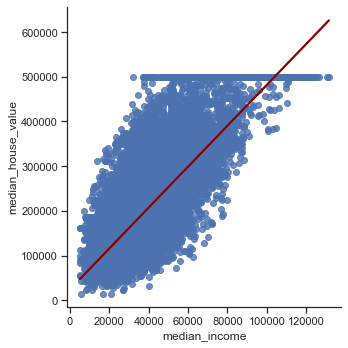

In [155]:
# plot with seaborn
sns.set_theme(style="ticks")

sns.lmplot(x='median_income', y='median_house_value', data=train_dataset, line_kws={'color': 'darkred'}, ci=False);

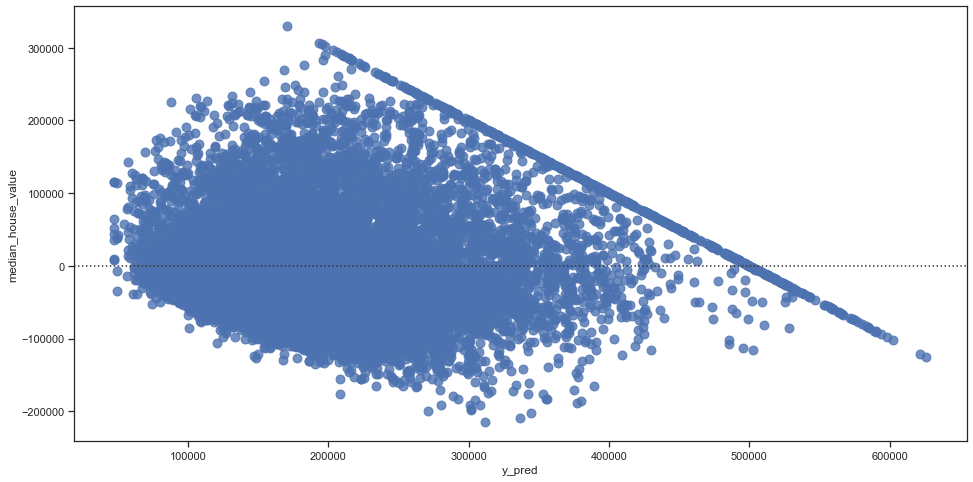

In [156]:
sns.residplot(x="y_pred", y="median_house_value", data=train_dataset, scatter_kws={"s": 80});

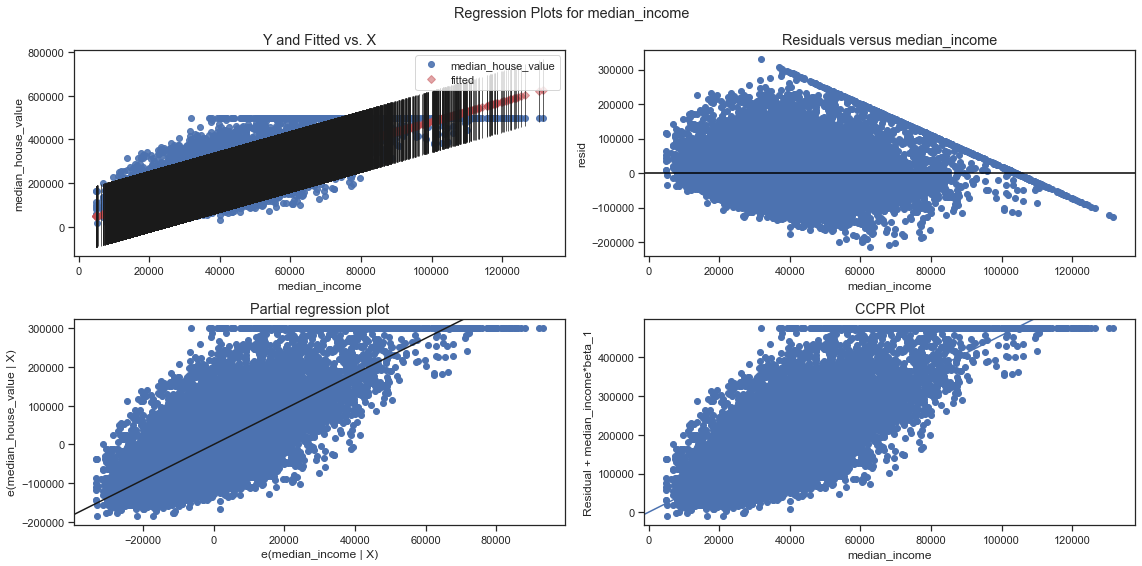

In [157]:
fig = sm.graphics.plot_regress_exog(lm, "median_income")
fig.tight_layout(pad=1.0)

Due to the huge amount of data points it is hard to interprete these graphs. The y and Fitted vs x can not be interpreted.
It can be seen that this models fits on the data distribution and is good but not perfect in predicting the results. There is still a difference on the predictions and the result. But this model is going in the right direction (similar distribution in the CCPR plot on both sides)

### Validation with test data

In [158]:
# Add regression predictions for the test set (as "pred_test") to our DataFrame
test_dataset['y_pred'] = lm.predict(test_dataset['median_income'])

test_dataset.head()

median_housing_age  population  households  median_income  \
2                 52.0         496         177        72574.0   
11                52.0        1504         734        32705.0   
18                50.0         990         419        19911.0   
20                40.0         409         166        13578.0   
23                52.0         853         325        21806.0   

    median_house_value ocean_proximity  avg_rooms_per_household  \
2             352100.0        NEAR BAY                     8.29   
11            241800.0        NEAR BAY                     4.77   
18            158700.0        NEAR BAY                     5.34   
20            147500.0        NEAR BAY                     4.52   
23             99700.0        NEAR BAY                     5.19   

    avg_size_per_household         y_pred  
2                     2.80  356456.231289  
11                    2.05  174114.379707  
18                    2.36  115600.706197  
20                    2.46   86636.575016  
23                    2.62  124267.535281

In [159]:
# Plot regression line 
plt.scatter(test_dataset['median_income'], test_dataset['median_house_value'],  color='black')
plt.plot(test_dataset['median_income'], test_dataset['y_pred'], color='darkred', linewidth=3);

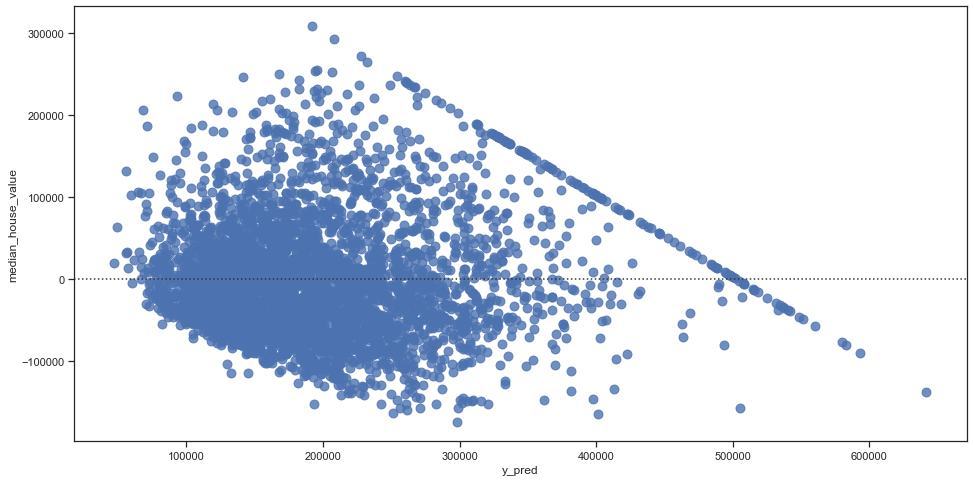

In [160]:
sns.residplot(x="y_pred", y="median_house_value", data=test_dataset, scatter_kws={"s": 80});

In [161]:
# MSE
print('MSE of the model is:', mse(test_dataset['median_house_value'], test_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(test_dataset['median_house_value'], test_dataset['y_pred']))

MSE of the model is: 5100442857.284637
RMSE of the model is: 71417.38483929972


The values on the test data set are similar to those on the training data set

## Modeling - Model 2
### Train the model

This model will only include the median_income and ocean_proximity as pradiktor variable

In [162]:
lm_2 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity', data=train_dataset).fit()

In [163]:
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     6112.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:09   Log-Likelihood:            -1.9533e+05
No. Observations:               15663   AIC:                         3.907e+05
Df Residuals:                   15657   BIC:                         3.907e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Ocean_proximity ISLAND does not affect the model since the p-value is above 5%
INLAND leads to a lower median_house_value
NEAR BAY and NEAR Ocean to a bigger median_houes_value
<1h OCEAN is not included - why?

Important statistics will be listed again

In [164]:

# Adjusted R squared 
print('Adjusted R squared of Model 2 is:', lm_2.rsquared_adj)
print('Adjusted R squared of Model 1 is:', lm.rsquared_adj)
# R sqaured
print('R squared is of Model 2 is:', lm_2.rsquared)
print('R squared is of Model 1 is:', lm.rsquared)
# F-Statistic
print('F-Statistic of Model 2 is:', lm_2.fvalue)
print('F-Statistic of Model 1 is:', lm.fvalue)

Adjusted R squared of Model 2 is: 0.6611106452986991
Adjusted R squared of Model 1 is: 0.5623997783613985
R squared is of Model 2 is: 0.6612188337020644
R squared is of Model 1 is: 0.5624277186130675
F-Statistic of Model 2 is: 6111.734836032003
F-Statistic of Model 1 is: 20129.65828932484


Conclusion:
Model 2 delivers better values for Adjusted R squared and R squared but much lower value for the F-Statistic.

In [165]:
# Add the regression predictions (as "pred") to our DataFrame
train_dataset['y_pred'] = lm_2.predict()

train_dataset

median_housing_age  population  households  median_income  \
11395                22.0        1454         488        66324.0   
2260                 24.0        2764         773        13385.0   
12456                16.0        2434         824        26797.0   
16                   52.0         793         331        27750.0   
13065                18.0         614         192        45766.0   
...                   ...         ...         ...            ...   
18630                36.0         677         206        58642.0   
19950                12.0        2191         804        35611.0   
12803                44.0         823         375        46625.0   
3551                 18.0         263         110        61288.0   
18767                18.0         750         252        51585.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
11395            347600.0       <1H OCEAN                     7.13   
2260              58800.0          INLAND                     4.19   
12456             86500.0          INLAND                     4.54   
16               152500.0        NEAR BAY                     5.94   
13065            108700.0          INLAND                     6.09   
...                   ...             ...                      ...   
18630            363500.0       <1H OCEAN                     7.39   
19950             90200.0          INLAND                     6.18   
12803            158900.0          INLAND                     6.20   
3551             350000.0       <1H OCEAN                     8.15   
18767            150800.0          INLAND                     6.48   

       avg_size_per_household         y_pred  
11395                    2.98  332367.549558  
2260                     3.58   47907.226916  
12456                    2.95  102848.980237  
16                       2.40  189790.735970  
13065                    3.20  180554.774955  
...                       ...            ...  
18630                    3.29  300898.525623  
19950                    2.73  138955.199577  
12803                    2.19  184073.636132  
3551                     2.39  311737.765057  
18767                    2.98  204392.089493  

[15663 rows x 9 columns]

In [166]:
# MSE
print('MSE of the model is:', mse(train_dataset['median_house_value'], train_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(train_dataset['median_house_value'], train_dataset['y_pred']))

MSE of the model is: 3975373412.0596995
RMSE of the model is: 63050.562345309016


Values are better than on model 1

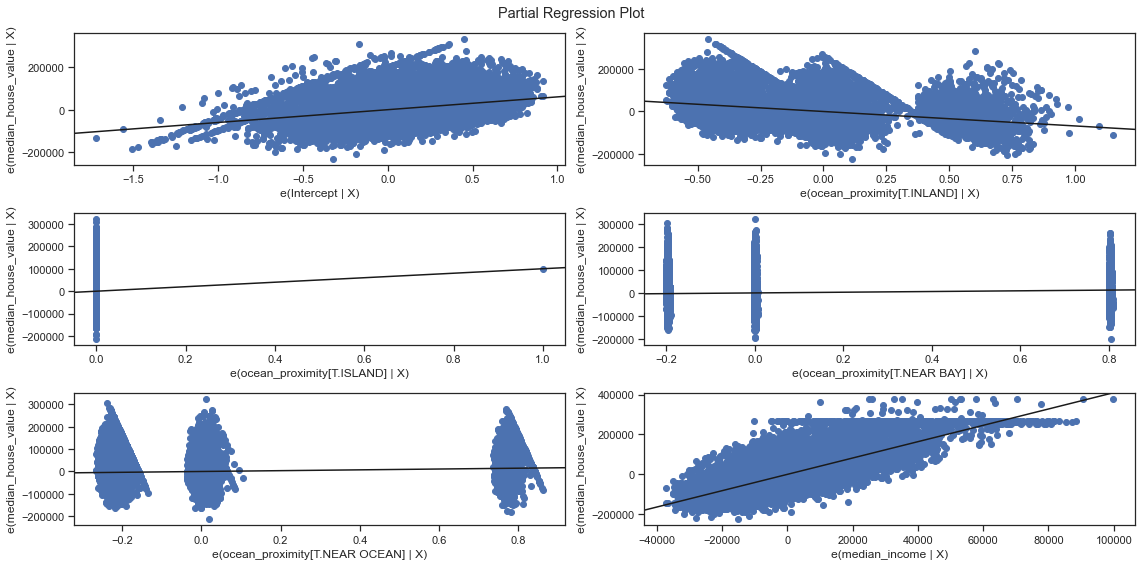

In [167]:
fig = sm.graphics.plot_partregress_grid(lm_2)
fig.tight_layout(pad=1.0)

No big influence of the Ocean_proximity can be seen

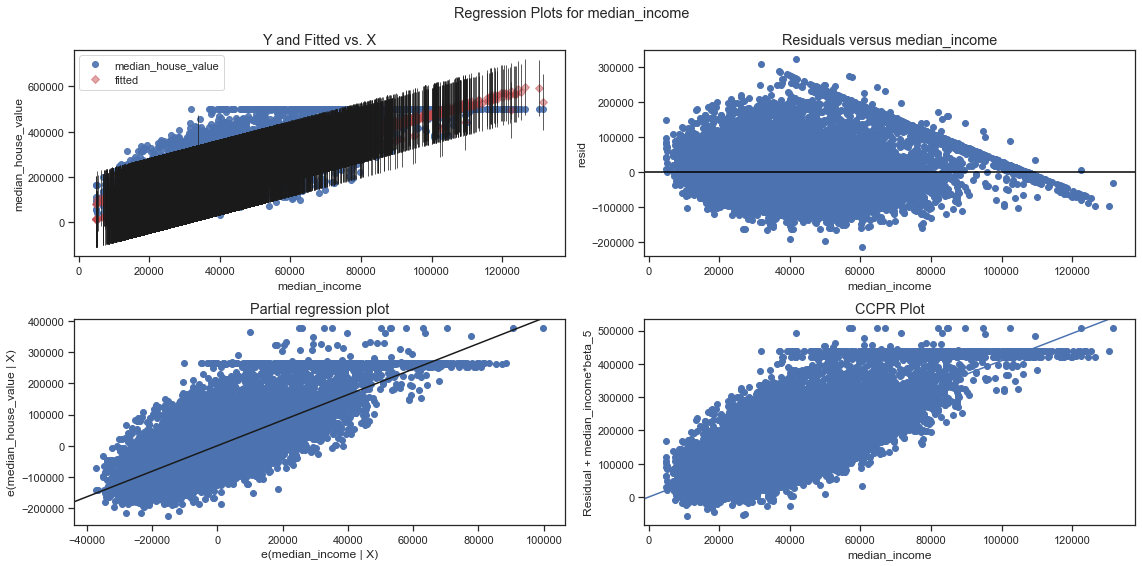

In [168]:
fig = sm.graphics.plot_regress_exog(lm_2, "median_income")
fig.tight_layout(pad=1.0)

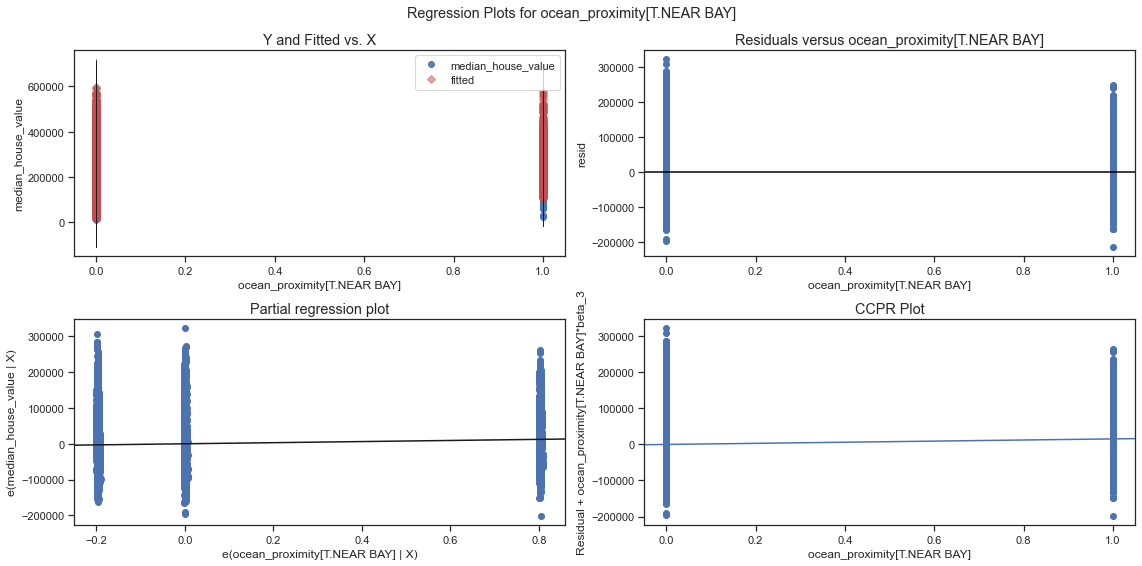

In [169]:
fig = sm.graphics.plot_regress_exog(lm_2, "ocean_proximity[T.NEAR BAY]")
fig.tight_layout(pad=1.0)

No big influence of the Ocean_proximity can be seen. The influence is only minor (small slope of in the plots).

### Validation with test data


In [170]:
# Add regression predictions for the test set (as "pred_test") to our DataFrame

test_dataset['y_pred'] = lm_2.predict(test_dataset)

test_dataset.head()

 

median_housing_age  population  households  median_income  \
2                 52.0         496         177        72574.0   
11                52.0        1504         734        32705.0   
18                50.0         990         419        19911.0   
20                40.0         409         166        13578.0   
23                52.0         853         325        21806.0   

    median_house_value ocean_proximity  avg_rooms_per_household  \
2             352100.0        NEAR BAY                     8.29   
11            241800.0        NEAR BAY                     4.77   
18            158700.0        NEAR BAY                     5.34   
20            147500.0        NEAR BAY                     4.52   
23             99700.0        NEAR BAY                     5.19   

    avg_size_per_household         y_pred  
2                     2.80  373410.565294  
11                    2.05  210088.707019  
18                    2.36  157678.567443  
20                    2.46  131735.671246  
23                    2.62  165441.363636

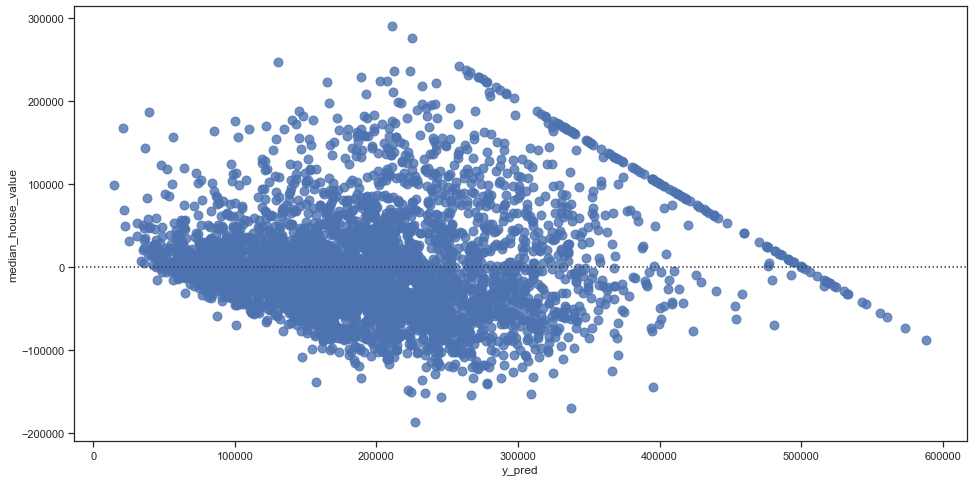

In [171]:
sns.residplot(x="y_pred", y="median_house_value", data=test_dataset, scatter_kws={"s": 80});

The distance beetween the real values and the predicted values is smaller than for the previous model

In [172]:
# MSE
print('MSE of the model is:', mse(test_dataset['median_house_value'], test_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(test_dataset['median_house_value'], test_dataset['y_pred']))

MSE of the model is: 3881164534.3400526
RMSE of the model is: 62298.99304435067


These two values are lower than for the values of Model 1. Also they are similar to those from the training data (they are even a bit lower)

## Modeling - Model 3
### Train the model

Step by step all variables will be added to the model.
This model now contrains the median_house_value, ocean_proximity and the avg_rooms_per_household.
Lets see when the model will be overfitted :)

In [173]:
lm_3 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + avg_rooms_per_household', data=train_dataset).fit()

In [174]:
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     5122.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:14   Log-Likelihood:            -1.9530e+05
No. Observations:               15663   AIC:                         3.906e+05
Df Residuals:                   15656   BIC:                         3.907e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Same as for the previous model:

Ocean_proximity ISLAND does not affect the model since the p-value is above 5%
INLAND leads to a lower median_house_value
NEAR BAY and NEAR Ocean to a bigger median_houes_value
<1h OCEAN is not included - why?

Important statistics will be listed again

In [175]:

# Adjusted R squared 
print('Adjusted R squared of Model 3 is:', lm_3.rsquared_adj)
print('Adjusted R squared of Model 2 is:', lm_2.rsquared_adj)
print('Adjusted R squared of Model 1 is:', lm.rsquared_adj)
# R sqaured
print('R squared is of Model 3 is:', lm_3.rsquared)
print('R squared is of Model 2 is:', lm_2.rsquared)
print('R squared is of Model 1 is:', lm.rsquared)
# F-Statistic
print('F-Statistic of Model 3 is:', lm_3.fvalue)
print('F-Statistic of Model 2 is:', lm_2.fvalue)
print('F-Statistic of Model 1 is:', lm.fvalue)

Adjusted R squared of Model 3 is: 0.6623845537946063
Adjusted R squared of Model 2 is: 0.6611106452986991
Adjusted R squared of Model 1 is: 0.5623997783613985
R squared is of Model 3 is: 0.6625138918534258
R squared is of Model 2 is: 0.6612188337020644
R squared is of Model 1 is: 0.5624277186130675
F-Statistic of Model 3 is: 5122.342935249755
F-Statistic of Model 2 is: 6111.734836032003
F-Statistic of Model 1 is: 20129.65828932484


Conclusion: Model 3 delivers best value for Adjusted R squared and R squared but also lowest value for the F-Statistic

In [176]:
# Add the regression predictions (as "pred") to our DataFrame
train_dataset['y_pred'] = lm_3.predict()

train_dataset

median_housing_age  population  households  median_income  \
11395                22.0        1454         488        66324.0   
2260                 24.0        2764         773        13385.0   
12456                16.0        2434         824        26797.0   
16                   52.0         793         331        27750.0   
13065                18.0         614         192        45766.0   
...                   ...         ...         ...            ...   
18630                36.0         677         206        58642.0   
19950                12.0        2191         804        35611.0   
12803                44.0         823         375        46625.0   
3551                 18.0         263         110        61288.0   
18767                18.0         750         252        51585.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
11395            347600.0       <1H OCEAN                     7.13   
2260              58800.0          INLAND                     4.19   
12456             86500.0          INLAND                     4.54   
16               152500.0        NEAR BAY                     5.94   
13065            108700.0          INLAND                     6.09   
...                   ...             ...                      ...   
18630            363500.0       <1H OCEAN                     7.39   
19950             90200.0          INLAND                     6.18   
12803            158900.0          INLAND                     6.20   
3551             350000.0       <1H OCEAN                     8.15   
18767            150800.0          INLAND                     6.48   

       avg_size_per_household         y_pred  
11395                    2.98  330327.065586  
2260                     3.58   49778.645695  
12456                    2.95  105792.769213  
16                       2.40  185569.193339  
13065                    3.20  181867.286452  
...                       ...            ...  
18630                    3.29  296869.825804  
19950                    2.73  138396.459081  
12803                    2.19  185193.489798  
3551                     2.39  305858.906417  
18767                    2.98  205459.258730  

[15663 rows x 9 columns]

In [177]:
# MSE
print('MSE of the model is:', mse(train_dataset['median_house_value'], train_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(train_dataset['median_house_value'], train_dataset['y_pred']))

MSE of the model is: 3960176759.3111043
RMSE of the model is: 62929.9353194575


These values are lower than for the previous models

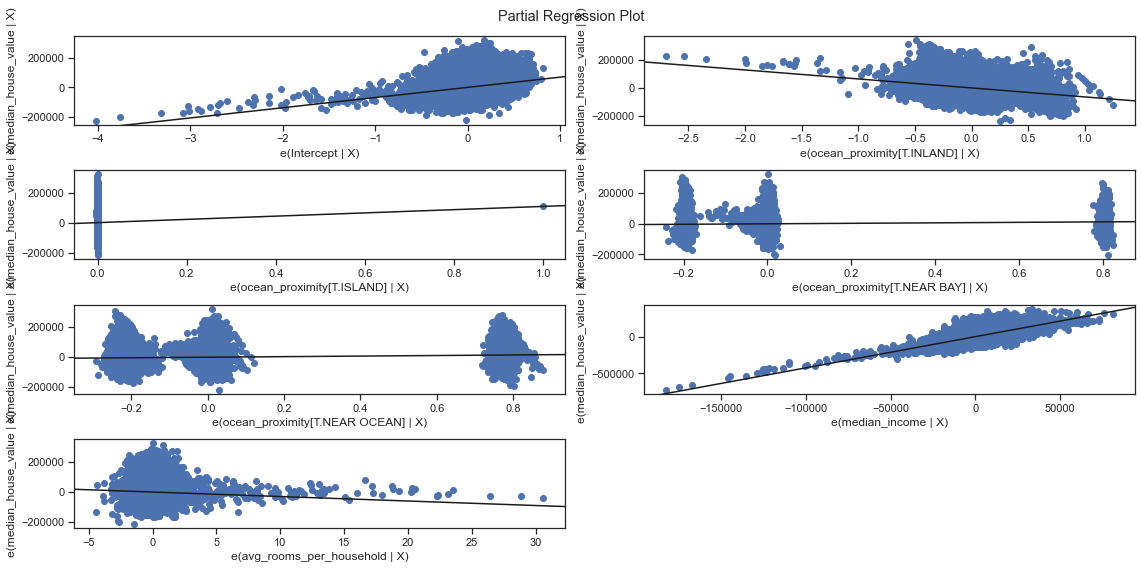

In [178]:
fig = sm.graphics.plot_partregress_grid(lm_3)
fig.tight_layout(pad=1.0)

### Validation with test data


In [179]:
# Add regression predictions for the test set (as "pred_test") to our DataFrame

test_dataset['y_pred'] = lm_3.predict(test_dataset)

test_dataset.head()

median_housing_age  population  households  median_income  \
2                 52.0         496         177        72574.0   
11                52.0        1504         734        32705.0   
18                50.0         990         419        19911.0   
20                40.0         409         166        13578.0   
23                52.0         853         325        21806.0   

    median_house_value ocean_proximity  avg_rooms_per_household  \
2             352100.0        NEAR BAY                     8.29   
11            241800.0        NEAR BAY                     4.77   
18            158700.0        NEAR BAY                     5.34   
20            147500.0        NEAR BAY                     4.52   
23             99700.0        NEAR BAY                     5.19   

    avg_size_per_household         y_pred  
2                     2.80  369251.164673  
11                    2.05  210140.339686  
18                    2.36  154010.180968  
20                    2.46  129514.580739  
23                    2.62  162519.637754

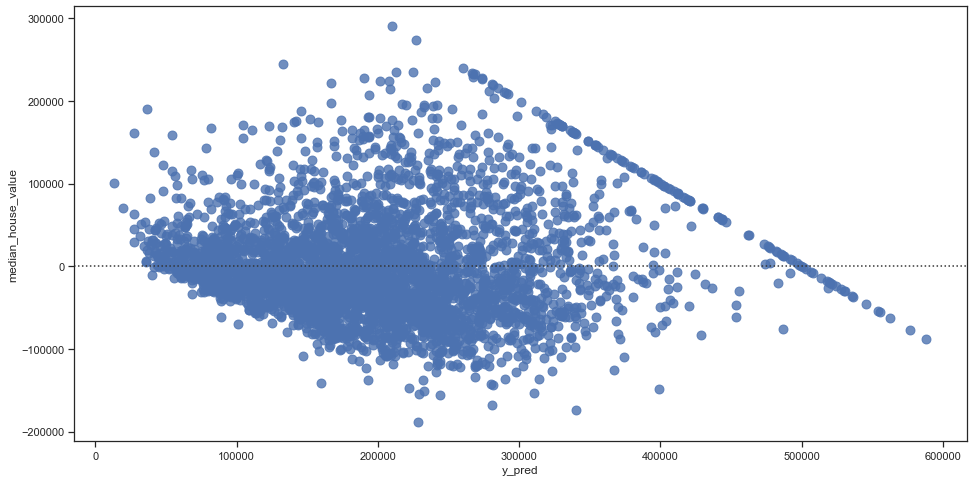

In [180]:
sns.residplot(x="y_pred", y="median_house_value", data=test_dataset, scatter_kws={"s": 80});

Seems like model 2 was better with the predictions for the test data

In [181]:
# MSE
print('MSE of the model is:', mse(test_dataset['median_house_value'], test_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(test_dataset['median_house_value'], test_dataset['y_pred']))

MSE of the model is: 3863943532.6300755
RMSE of the model is: 62160.62686805914


But the MSE and RMSE are lower than those for model 1 and 2. Also they are similar to the training data (they are even lower)

## Modeling - Model 4
### Train the model

Step by step all variables will be added to the model.
This model now contrains the median_house_value, ocean_proximity, avg_rooms_per_household and the population.
Lets see when the model will be overfitted :)

In [182]:
lm_4 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + population + avg_rooms_per_household', data=train_dataset).fit()

In [183]:
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     4415.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:16   Log-Likelihood:            -1.9527e+05
No. Observations:               15663   AIC:                         3.906e+05
Df Residuals:                   15655   BIC:                         3.906e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [184]:
# Adjusted R squared 
print('Adjusted R squared of Model 4 is:', lm_4.rsquared_adj)
print('Adjusted R squared of Model 3 is:', lm_3.rsquared_adj)
print('Adjusted R squared of Model 2 is:', lm_2.rsquared_adj)
print('Adjusted R squared of Model 1 is:', lm.rsquared_adj)
# R sqaured
print('R squared is of Model 4 is:', lm_4.rsquared)
print('R squared is of Model 3 is:', lm_3.rsquared)
print('R squared is of Model 2 is:', lm_2.rsquared)
print('R squared is of Model 1 is:', lm.rsquared)
# F-Statistic
print('F-Statistic of Model 4 is:', lm_4.fvalue)
print('F-Statistic of Model 3 is:', lm_3.fvalue)
print('F-Statistic of Model 2 is:', lm_2.fvalue)
print('F-Statistic of Model 1 is:', lm.fvalue)

Adjusted R squared of Model 4 is: 0.6636258345211483
Adjusted R squared of Model 3 is: 0.6623845537946063
Adjusted R squared of Model 2 is: 0.6611106452986991
Adjusted R squared of Model 1 is: 0.5623997783613985
R squared is of Model 4 is: 0.6637761741430581
R squared is of Model 3 is: 0.6625138918534258
R squared is of Model 2 is: 0.6612188337020644
R squared is of Model 1 is: 0.5624277186130675
F-Statistic of Model 4 is: 4415.177886645988
F-Statistic of Model 3 is: 5122.342935249755
F-Statistic of Model 2 is: 6111.734836032003
F-Statistic of Model 1 is: 20129.65828932484


Conclusion: Model 4 delivers best value for Adjusted R squared (increasement is very small)and R squared but also lowest value for the F-Statistic. But R2 increases if more variables are added to the dataframe

In [185]:
# Add the regression predictions (as "pred") to our DataFrame
train_dataset['y_pred'] = lm_4.predict()

train_dataset

median_housing_age  population  households  median_income  \
11395                22.0        1454         488        66324.0   
2260                 24.0        2764         773        13385.0   
12456                16.0        2434         824        26797.0   
16                   52.0         793         331        27750.0   
13065                18.0         614         192        45766.0   
...                   ...         ...         ...            ...   
18630                36.0         677         206        58642.0   
19950                12.0        2191         804        35611.0   
12803                44.0         823         375        46625.0   
3551                 18.0         263         110        61288.0   
18767                18.0         750         252        51585.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
11395            347600.0       <1H OCEAN                     7.13   
2260              58800.0          INLAND                     4.19   
12456             86500.0          INLAND                     4.54   
16               152500.0        NEAR BAY                     5.94   
13065            108700.0          INLAND                     6.09   
...                   ...             ...                      ...   
18630            363500.0       <1H OCEAN                     7.39   
19950             90200.0          INLAND                     6.18   
12803            158900.0          INLAND                     6.20   
3551             350000.0       <1H OCEAN                     8.15   
18767            150800.0          INLAND                     6.48   

       avg_size_per_household         y_pred  
11395                    2.98  330301.583038  
2260                     3.58   44170.509611  
12456                    2.95  101645.909476  
16                       2.40  186878.943814  
13065                    3.20  184955.862102  
...                       ...            ...  
18630                    3.29  299773.268565  
19950                    2.73  134947.432732  
12803                    2.19  187427.063718  
3551                     2.39  310273.989395  
18767                    2.98  207996.713891  

[15663 rows x 9 columns]

In [186]:
# MSE
print('MSE of the model is:', mse(train_dataset['median_house_value'], train_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(train_dataset['median_house_value'], train_dataset['y_pred']))

MSE of the model is: 3945364709.6698775
RMSE of the model is: 62812.13823513635


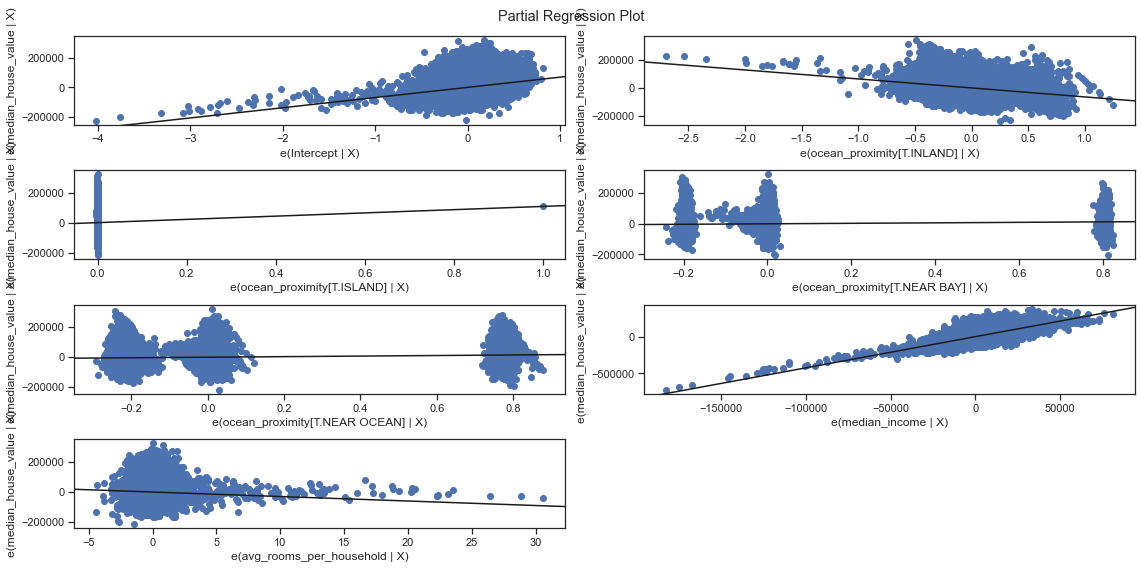

In [187]:
fig = sm.graphics.plot_partregress_grid(lm_3)
fig.tight_layout(pad=1.0)

### Validation with test data


In [188]:
# Add regression predictions for the test set (as "pred_test") to our DataFrame

test_dataset['y_pred'] = lm_4.predict(test_dataset)

test_dataset.head()

median_housing_age  population  households  median_income  \
2                 52.0         496         177        72574.0   
11                52.0        1504         734        32705.0   
18                50.0         990         419        19911.0   
20                40.0         409         166        13578.0   
23                52.0         853         325        21806.0   

    median_house_value ocean_proximity  avg_rooms_per_household  \
2             352100.0        NEAR BAY                     8.29   
11            241800.0        NEAR BAY                     4.77   
18            158700.0        NEAR BAY                     5.34   
20            147500.0        NEAR BAY                     4.52   
23             99700.0        NEAR BAY                     5.19   

    avg_size_per_household         y_pred  
2                     2.80  371895.095557  
11                    2.05  208978.151440  
18                    2.36  154552.359651  
20                    2.46  132501.447429  
23                    2.62  163683.825485

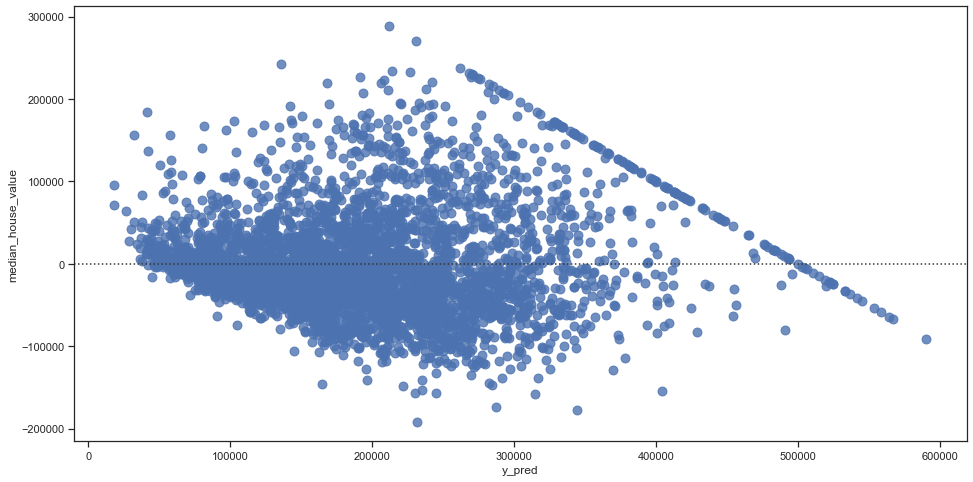

In [189]:
sns.residplot(x="y_pred", y="median_house_value", data=test_dataset, scatter_kws={"s": 80});

It is hard so see a difference to model 4 due to the amount of data

In [190]:
# MSE
print('MSE of the model is:', mse(test_dataset['median_house_value'], test_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(test_dataset['median_house_value'], test_dataset['y_pred']))

MSE of the model is: 3854408858.6885266
RMSE of the model is: 62083.885660358974


But the MSE and RMSE are lower than those for model 1 and 2. Also they are similar to the training data (they are even lower)

## Modeling - Model 5
### Train the model
Step by step all variables will be added to the model.
This model now contrains the median_house_value, ocean_proximity, avg_rooms_per_household and the population and households.
Lets see when the model will be overfitted :)
In this model population and household is added (it was classified from the VIF factor that this is shall not be don added to the model. Due to the fact that the VIF factor was above 5 and this means that this indicates a problematic amount of collinearity and the parameter estimates will have large standard errors because of this.)

In [191]:
lm_5 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + avg_rooms_per_household + population + households', data=train_dataset).fit()

In [192]:
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4467.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:19   Log-Likelihood:            -1.9450e+05
No. Observations:               15663   AIC:                         3.890e+05
Df Residuals:                   15654   BIC:                         3.891e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

This model has the highes R-squared values, F-statis value also starts to increase (compared to Model 4)

Also BIC and AIC values are very high due to all the variables in the model

In [193]:
# Adjusted R squared 
print('Adjusted R squared of Model 5 is:', lm_5.rsquared_adj)
print('Adjusted R squared of Model 4 is:', lm_4.rsquared_adj)
print('Adjusted R squared of Model 3 is:', lm_3.rsquared_adj)
print('Adjusted R squared of Model 2 is:', lm_2.rsquared_adj)
print('Adjusted R squared of Model 1 is:', lm.rsquared_adj)
# R sqaured
print('R squared is of Model 5 is:', lm_5.rsquared)
print('R squared is of Model 4 is:', lm_4.rsquared)
print('R squared is of Model 3 is:', lm_3.rsquared)
print('R squared is of Model 2 is:', lm_2.rsquared)
print('R squared is of Model 1 is:', lm.rsquared)
# F-Statistic
print('F-Statistic of Model 5 is:', lm_5.fvalue)
print('F-Statistic of Model 4 is:', lm_4.fvalue)
print('F-Statistic of Model 3 is:', lm_3.fvalue)
print('F-Statistic of Model 2 is:', lm_2.fvalue)
print('F-Statistic of Model 1 is:', lm.fvalue)

Adjusted R squared of Model 5 is: 0.6952129061812578
Adjusted R squared of Model 4 is: 0.6636258345211483
Adjusted R squared of Model 3 is: 0.6623845537946063
Adjusted R squared of Model 2 is: 0.6611106452986991
Adjusted R squared of Model 1 is: 0.5623997783613985
R squared is of Model 5 is: 0.6953685885175207
R squared is of Model 4 is: 0.6637761741430581
R squared is of Model 3 is: 0.6625138918534258
R squared is of Model 2 is: 0.6612188337020644
R squared is of Model 1 is: 0.5624277186130675
F-Statistic of Model 5 is: 4466.586288524999
F-Statistic of Model 4 is: 4415.177886645988
F-Statistic of Model 3 is: 5122.342935249755
F-Statistic of Model 2 is: 6111.734836032003
F-Statistic of Model 1 is: 20129.65828932484


In [194]:
# Add the regression predictions (as "pred") to our DataFrame
train_dataset['y_pred'] = lm_5.predict()

train_dataset

median_housing_age  population  households  median_income  \
11395                22.0        1454         488        66324.0   
2260                 24.0        2764         773        13385.0   
12456                16.0        2434         824        26797.0   
16                   52.0         793         331        27750.0   
13065                18.0         614         192        45766.0   
...                   ...         ...         ...            ...   
18630                36.0         677         206        58642.0   
19950                12.0        2191         804        35611.0   
12803                44.0         823         375        46625.0   
3551                 18.0         263         110        61288.0   
18767                18.0         750         252        51585.0   

       median_house_value ocean_proximity  avg_rooms_per_household  \
11395            347600.0       <1H OCEAN                     7.13   
2260              58800.0          INLAND                     4.19   
12456             86500.0          INLAND                     4.54   
16               152500.0        NEAR BAY                     5.94   
13065            108700.0          INLAND                     6.09   
...                   ...             ...                      ...   
18630            363500.0       <1H OCEAN                     7.39   
19950             90200.0          INLAND                     6.18   
12803            158900.0          INLAND                     6.20   
3551             350000.0       <1H OCEAN                     8.15   
18767            150800.0          INLAND                     6.48   

       avg_size_per_household         y_pred  
11395                    2.98  329512.678273  
2260                     3.58   23746.325234  
12456                    2.95  104096.977894  
16                       2.40  186751.429973  
13065                    3.20  177836.062749  
...                       ...            ...  
18630                    3.29  293823.777622  
19950                    2.73  146461.192699  
12803                    2.19  198217.894073  
3551                     2.39  309804.462755  
18767                    2.98  203392.677256  

[15663 rows x 9 columns]

In [195]:
# MSE
print('MSE of the model is:', mse(train_dataset['median_house_value'], train_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(train_dataset['median_house_value'], train_dataset['y_pred']))

MSE of the model is: 3574648576.0092416
RMSE of the model is: 59788.364888239266


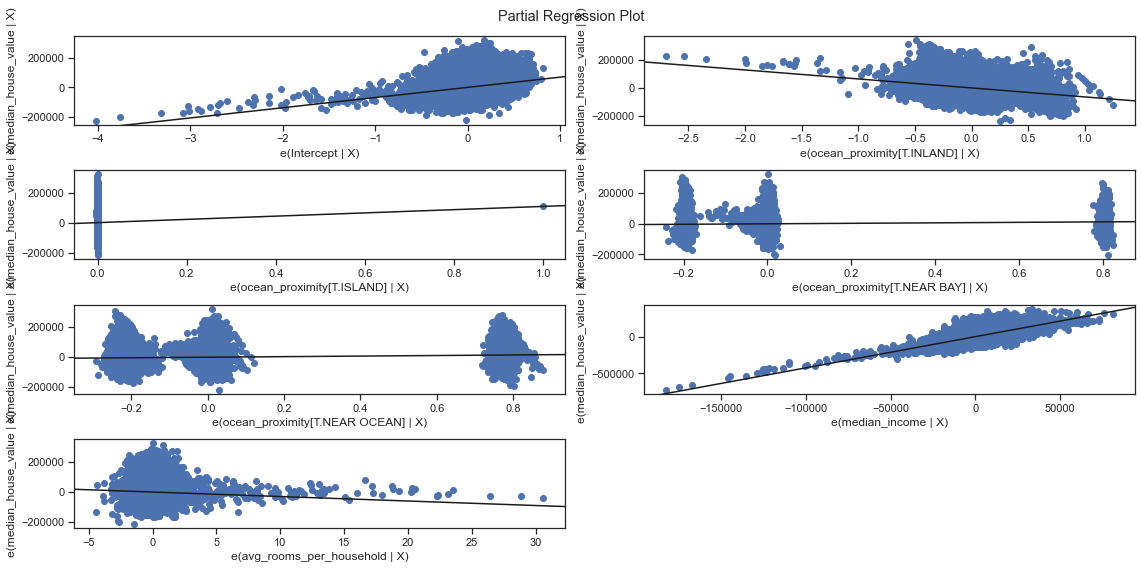

In [196]:
fig = sm.graphics.plot_partregress_grid(lm_3)
fig.tight_layout(pad=1.0)

### Validation with test data
--> this will be skipped because this model has performs wors (R² and F-statistic) than the previous models

## Modeling - Model 6
### Train the Model

This model now includes all variables

In [197]:
lm_6 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + avg_rooms_per_household + median_housing_age + population + households + avg_size_per_household', data=train_dataset).fit()

In [198]:
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     3907.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:20   Log-Likelihood:            -1.9400e+05
No. Observations:               15663   AIC:                         3.880e+05
Df Residuals:                   15652   BIC:                         3.881e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [199]:
# Adjusted R squared 
print('Adjusted R squared of Model 6 is:', lm_6.rsquared_adj)
print('Adjusted R squared of Model 5 is:', lm_5.rsquared_adj)
print('Adjusted R squared of Model 4 is:', lm_4.rsquared_adj)
print('Adjusted R squared of Model 3 is:', lm_3.rsquared_adj)
print('Adjusted R squared of Model 2 is:', lm_2.rsquared_adj)
print('Adjusted R squared of Model 1 is:', lm.rsquared_adj)
# R sqaured
print('R squared is of Model 6 is:', lm_6.rsquared)
print('R squared is of Model 5 is:', lm_5.rsquared)
print('R squared is of Model 4 is:', lm_4.rsquared)
print('R squared is of Model 3 is:', lm_3.rsquared)
print('R squared is of Model 2 is:', lm_2.rsquared)
print('R squared is of Model 1 is:', lm.rsquared)
# F-Statistic
print('F-Statistic of Model 6 is:', lm_6.fvalue)
print('F-Statistic of Model 5 is:', lm_5.fvalue)
print('F-Statistic of Model 4 is:', lm_4.fvalue)
print('F-Statistic of Model 3 is:', lm_3.fvalue)
print('F-Statistic of Model 2 is:', lm_2.fvalue)
print('F-Statistic of Model 1 is:', lm.fvalue)

Adjusted R squared of Model 6 is: 0.7137887574470749
Adjusted R squared of Model 5 is: 0.6952129061812578
Adjusted R squared of Model 4 is: 0.6636258345211483
Adjusted R squared of Model 3 is: 0.6623845537946063
Adjusted R squared of Model 2 is: 0.6611106452986991
Adjusted R squared of Model 1 is: 0.5623997783613985
R squared is of Model 6 is: 0.713971499908161
R squared is of Model 5 is: 0.6953685885175207
R squared is of Model 4 is: 0.6637761741430581
R squared is of Model 3 is: 0.6625138918534258
R squared is of Model 2 is: 0.6612188337020644
R squared is of Model 1 is: 0.5624277186130675
F-Statistic of Model 6 is: 3906.9819661237966
F-Statistic of Model 5 is: 4466.586288524999
F-Statistic of Model 4 is: 4415.177886645988
F-Statistic of Model 3 is: 5122.342935249755
F-Statistic of Model 2 is: 6111.734836032003
F-Statistic of Model 1 is: 20129.65828932484


Conclusion: This model has the best values for R squared and adjusted R squared but also the lowest for the F-statistic

### Validation with test data


In [200]:
# Add regression predictions for the test set (as "pred_test") to our DataFrame

test_dataset['y_pred'] = lm_6.predict(test_dataset)

test_dataset.head()

median_housing_age  population  households  median_income  \
2                 52.0         496         177        72574.0   
11                52.0        1504         734        32705.0   
18                50.0         990         419        19911.0   
20                40.0         409         166        13578.0   
23                52.0         853         325        21806.0   

    median_house_value ocean_proximity  avg_rooms_per_household  \
2             352100.0        NEAR BAY                     8.29   
11            241800.0        NEAR BAY                     4.77   
18            158700.0        NEAR BAY                     5.34   
20            147500.0        NEAR BAY                     4.52   
23             99700.0        NEAR BAY                     5.19   

    avg_size_per_household         y_pred  
2                     2.80  383051.157188  
11                    2.05  255407.468294  
18                    2.36  172986.005177  
20                    2.46  122445.122221  
23                    2.62  175049.200416

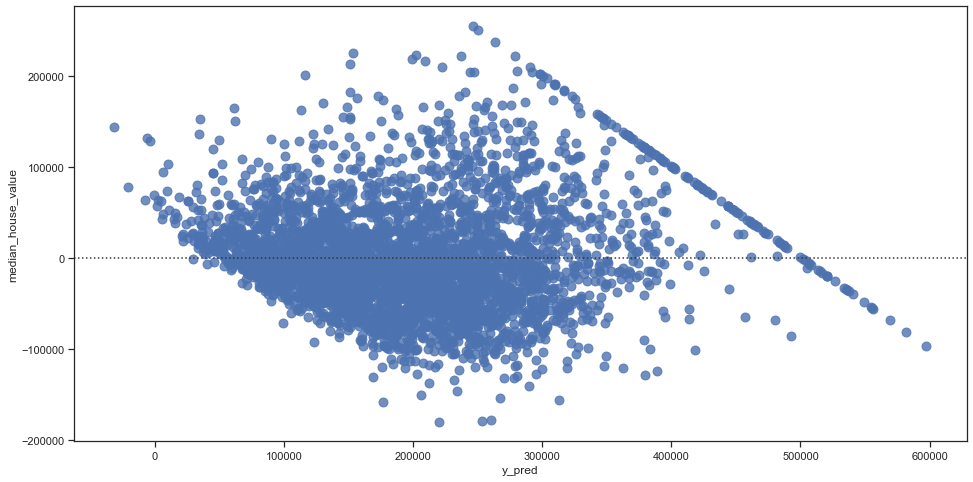

In [201]:
sns.residplot(x="y_pred", y="median_house_value", data=test_dataset, scatter_kws={"s": 80});

Due to the amount of data it is hard to see a difference

In [202]:
# MSE
print('MSE of the model is:', mse(test_dataset['median_house_value'], test_dataset['y_pred']))

#RMSE
print('RMSE of the model is:', rmse(test_dataset['median_house_value'], test_dataset['y_pred']))

MSE of the model is: 3302631393.847255
RMSE of the model is: 57468.525245104865


Lowert values for MSE and RMSE

This model is superior regarding the RMSE and MSE values!

## Model 7
New model will be made with the input from the feature selection (can be found at the end of the notebook)

In [203]:
lm_7 = smf.ols(formula='median_house_value ~ median_income + ocean_proximity + households', data=train_dataset).fit()

In [204]:
lm_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     5129.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:21   Log-Likelihood:            -1.9529e+05
No. Observations:               15663   AIC:                         3.906e+05
Df Residuals:                   15656   BIC:                         3.906e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      5.439e+04   1624.268     33.485      0.000    5.12e+04    5.76e+04
ocean_proximity[T.INLAND]      -6.72e+04   1203.809    -55.822      0.000   -6.96e+04   -6.48e+04
ocean_proximity[T.ISLAND]      1.031e+05   6.29e+04      1.639      0.101   -2.02e+04    2.26e+05
ocean_proximity[T.NEAR BAY]    1.573e+04   1709.437      9.203      0.000    1.24e+04    1.91e+04
ocean_proximity[T.NEAR OCEAN]  1.831e+04   1593.985     11.485      0.000    1.52e+04    2.14e+04
median_income                     4.0907      0.029    139.499      0.000       4.033       4.148
households                       13.1236      1.537      8.540      0.000      10.111      16.136
==============================================================================
Omnibus:                     2197.156   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3697.323
Skew:                           0.945   Prob(JB):                         0.00
Kurtosis:                       4.448   Cond. No.                     5.28e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Conclusion:
This model has no benefit compared to the previous models...

## Model 8
This model will only include numerical variables, as the categorical variable reduced the F-statistic a lot.
Also the task is to analyze a model with atleast 4 numeric variables **Update: I just looked up the task description, the analysis is only necessary for the EDA and not to add 4 numerical variables into a model. This is why this model will not be continued**

The following variables will be used:
- median_income (it was seen that this variable affects the data)
- households (see feature importance), population will not be used due to the multicollinarity
- median_housing age (see feature importance)
- avg_size_per_household (see feature importance, only avg_rooms per household will not be used to the small impact it has on the median_house_value)

Note if I only use median_income and households (the two numerical features with the biggest influence, then the F-statistic is at 10170, which is much higher but still lower than for the model with only median_income). That is why I do not add this as a model.
So model 1 has the highest F-statistic

In [205]:
lm_8 = smf.ols(formula='median_house_value ~ median_income + households + median_housing_age + avg_size_per_household', data=train_dataset).fit()

In [206]:
print(lm_8.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     6896.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:31:21   Log-Likelihood:            -1.9585e+05
No. Observations:               15663   AIC:                         3.917e+05
Df Residuals:                   15658   BIC:                         3.917e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -6510

In [207]:
# Adjusted R squared 
print('Adjusted R squared is:', lm_8.rsquared_adj)

# R sqaured
print('R squared is:', lm_8.rsquared)

# F-Statistic
print('F-Statistic is:', lm_8.fvalue)



Adjusted R squared is: 0.6378118550741576
R squared is: 0.6379043561966007
F-Statistic is: 6896.1796284061


This model does not perform as good as expected, the R² increased but I also expected the F-statistic to be much higher

# Preparation for sklearn
### Data preprocessing pipeline

The steps which shall be made be the preprocessing pipeline were already made manually at the beginning where I thought it makes sense to clean up the data. Below are the steps added how the should be normally made (without cleaning the data up in advance).

In [208]:
# Modules
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [209]:
# for numeric features
# simpleImputr --> übrall wo daten fehlen --> median
# Standardscaler --> verwendung eines standardskalers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])


In [210]:
# for categorical features  
# SimpleImputer --> fehlende zeilen werden mit konstante gefüllt
# onehotEncoder --> transponierung der tabelle, so dass zu kategorie die möglichen attribute pro spalte stehen. Diese werden dann per 0, 0 und 1 für unzutreffend und zutreffend gekennzeichnet
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])


In [211]:
# Pipeline wird gebaut, nummerische für alle außer kategorie und für categotische für all kategorischen
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])


### Data splitting with sklearn plus adding dummy variables.

But I think this is not necessary because I am using the preprocessor pipeline

In [219]:
# change the column Ocean Proximity to dummy variables
dummies = pd.get_dummies(df[['ocean_proximity']])

In [220]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ocean_proximity_<1H OCEAN   19579 non-null  uint8
 1   ocean_proximity_INLAND      19579 non-null  uint8
 2   ocean_proximity_ISLAND      19579 non-null  uint8
 3   ocean_proximity_NEAR BAY    19579 non-null  uint8
 4   ocean_proximity_NEAR OCEAN  19579 non-null  uint8
dtypes: uint8(5)
memory usage: 764.6 KB


In [221]:
print(dummies.head)

<bound method NDFrame.head of        ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
20635                          0                       1   
20636                          0                       1   
20637                          0                       1   
20638                          0                       1   
20639                          0                       1   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
0                           0                         1   
1                           0                         1   
2                           0                         1   
3            

# Linear Regression with Sklearn
The linear Regression will be made

## Multiple Regression
## Model 1

In [222]:
# drop median house value (as it is will be included in y and drop ocean_proximity as it will be added via the dummy variables)
X_numerical = df.drop(['median_house_value', 'ocean_proximity'], axis=1).astype('float64')


In [223]:
list_numerical = X_numerical.columns
list_numerical

Index(['median_housing_age', 'population', 'households', 'median_income',
       'avg_rooms_per_household', 'avg_size_per_household'],
      dtype='object')

In [225]:
# create label
y = df['median_house_value']

#create feature --> all columns except the median_house_value and ocean proximity, plus add the dummy variables
X = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

# create a list of feature names
feature_names = X.columns

X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_housing_age          19579 non-null  float64
 1   population                  19579 non-null  float64
 2   households                  19579 non-null  float64
 3   median_income               19579 non-null  float64
 4   avg_rooms_per_household     19579 non-null  float64
 5   avg_size_per_household      19579 non-null  float64
 6   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 7   ocean_proximity_INLAND      19579 non-null  uint8  
 8   ocean_proximity_ISLAND      19579 non-null  uint8  
 9   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 10  ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(6), uint8(5)
memory usage: 1.6 MB


In [226]:
from sklearn.model_selection import train_test_split
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [227]:
X_train.head()

median_housing_age  population  households  median_income  \
14041                27.0       880.0       400.0        24167.0   
19164                16.0       880.0       327.0        32857.0   
19710                22.0      1200.0       370.0        34426.0   
5462                 41.0       833.0       270.0        25938.0   
7486                 35.0      1870.0       412.0        30417.0   

       avg_rooms_per_household  avg_size_per_household  \
14041                     3.88                    2.20   
19164                     5.15                    2.69   
19710                     5.79                    3.24   
5462                      4.24                    3.09   
7486                      4.05                    4.54   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
14041                          0                       0   
19164                          1                       0   
19710                          0                       1   
5462                           1                       0   
7486                           1                       0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
14041                       0                         0   
19164                       0                         0   
19710                       0                         0   
5462                        0                         0   
7486                        0                         0   

       ocean_proximity_NEAR OCEAN  
14041                           1  
19164                           0  
19710                           0  
5462                            0  
7486                            0

In [228]:
y_train

14041    131300.0
19164    160200.0
19710    102400.0
5462     285000.0
7486     117300.0
           ...   
9885     174800.0
7667     158000.0
18724    111100.0
7670     174000.0
18668    322300.0
Name: median_house_value, Length: 15663, dtype: float64

In [229]:
from sklearn.linear_model import LinearRegression

# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm_sk', LinearRegression())
                        ])

In [230]:
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000293B729D5E0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
      

In [231]:
# Obtain model coefficients
lm_pipe.named_steps['lm_sk'].coef_

array([ 16184.44207181, -38718.81814754,  44096.36537117,  76726.73993453,
        -2784.65749155,  -5924.26204087,   9007.12622606, -19183.79266597,
         1287.96321705,   4037.27862883,   9768.20852122])

### Evaluation with training data

In [232]:
y_pred_train = lm_pipe.predict(X_train)

y_pred_train

array([181883.70608876, 179017.24174569, 122957.95020882, ...,
       153676.10081948, 189522.65896864, 288409.62707558])

In [233]:
from sklearn.metrics import r2_score

print("R2-Score of the model is:", r2_score(y_train, y_pred_train) )

R2-Score of the model is: 0.7116803678249832


In [234]:
from sklearn.metrics import mean_squared_error

print("Mean squared error of the model is:", mean_squared_error(y_train, y_pred_train))

Mean squared error of the model is: 3357880047.0979533


In [235]:
print("RMSE of the model is:", mean_squared_error(y_train, y_pred_train, squared=False))

RMSE of the model is: 57947.21776839638


In [236]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot with matplotlib
# plt.scatter(X_train, y_train,  color='black')
# plt.plot(X_train, y_pred_train, color='darkred', linewidth=3);

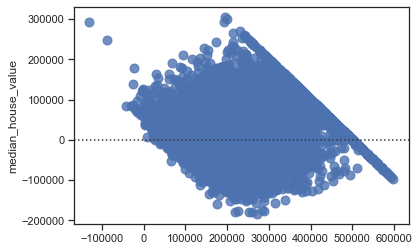

In [237]:
sns.residplot(x=y_pred_train, y=y_train, scatter_kws={"s": 80});

A lot of data is represented here, but it looks like that the distribution is equal on both sides of the zero line (which represents a correct prediction). But there are a lot of predictions which are far away


### Evaluation with test data

In [238]:
# make predictions for test data
y_pred_test = lm_pipe.predict(X_test)

In [239]:
print('Mean squared error of the model is:', mean_squared_error(y_test, y_pred_test))

print('RMSE of the model is:', mean_squared_error(y_test, y_pred_test, squared=False))

print("R2-Score of the model is:", r2_score(y_test, y_pred_test) )

Mean squared error of the model is: 3296948271.54336
RMSE of the model is: 57419.05843483817
R2-Score of the model is: 0.715930984723719


MSE, RMSE and R2 score are similar to the values from the test data, therefore the model works well with the training and with the test data 


## Model 2
This model only included the median_income

In [240]:
# Select features for the simple regression
features = ['median_income']

X = df[features]

# Create response
y = df['median_house_value']

In [241]:
# check feature
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   median_income  19579 non-null  float64
dtypes: float64(1)
memory usage: 822.0 KB


In [242]:
# check for missing values
# There wont be any missing values due to the fact that I cleaned up the data manually, normally the data preprocessor would take care of this
print("Missing values X:",X.isnull().any(axis=1).sum())

print("Missing values Y:",y.isnull().sum())

Missing values X: 0
Missing values Y: 0


### Data split

In [243]:
from sklearn.model_selection import train_test_split
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Modeling

In [244]:
from sklearn.linear_model import LinearRegression

# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

In [245]:
from sklearn import set_config

# show pipeline
set_config(display="diagram")
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000293B729D5E0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000293B729DCD0>)])),
                ('lm', LinearRegression())])

### Evaluation with training data

In [246]:
X_train.head()

median_income
14041        24167.0
19164        32857.0
19710        34426.0
5462         25938.0
7486         30417.0

In [247]:
y_pred = lm_pipe.predict(X_train)

y_pred

array([134873.85006307, 174616.32174327, 181791.91875895, ...,
       198608.152173  , 189996.5210828 , 247040.00201113])

In [248]:
# R squared
print('R squared is:',r2_score(y_train, y_pred))  
# MSE
print('MSE is:', mean_squared_error(y_train, y_pred))
#RMSE
print('RMSE is:' ,mean_squared_error(y_train, y_pred, squared=False))

R squared is: 0.5600925480201576
MSE is: 5123329425.851048
RMSE is: 71577.43656943191


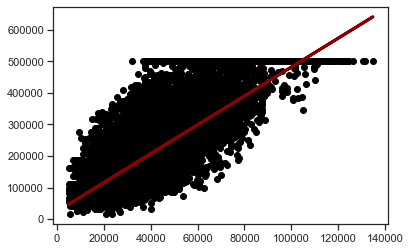

In [249]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot with matplotlib
plt.scatter(X_train, y_train,  color='black')
plt.plot(X_train, y_pred, color='darkred', linewidth=3);

Due to the huge amount of data, I do not know if these distribution around the prediction is normal or if the data points need to be closer to the line

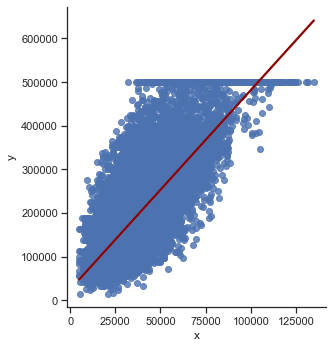

In [250]:
import seaborn as sns 
sns.set_theme(style="ticks")

# Plot with Seaborn

# We first need to create a DataFrame
df_train = pd.DataFrame({'x': X_train['median_income'], 'y':y_train})

sns.lmplot(x='x', y='y', data=df_train, line_kws={'color': 'darkred'}, ci=False);

Due to the huge amount of data, I do not know if these distribution around the prediction is normal or if the data points need to be closer to the line

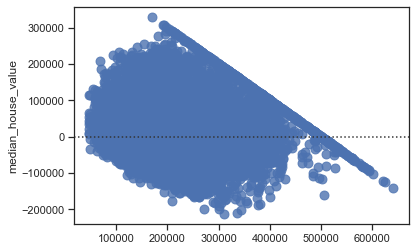

In [251]:
sns.residplot(x=y_pred, y=y_train, scatter_kws={"s": 80});

Due to the huge amount of data, I do not know if these distribution around the prediction is normal or if the data points need to be closer to the line

### Evaluation with test data

In [252]:
y_pred_test = lm_pipe.predict(X_test)

In [253]:
# R2 score
print("R2-Score of the model is:", r2_score(y_test, y_pred_test) )
# MSE
print('Mean squared error of the model is:', mean_squared_error(y_test, y_pred_test))
#RMSE
print('RMSE of the model is:', mean_squared_error(y_test, y_pred_test, squared=False))



R2-Score of the model is: 0.5566540157872919
Mean squared error of the model is: 5145541040.173503
RMSE of the model is: 71732.4266993213


Values are similar to those calculated on the training data set

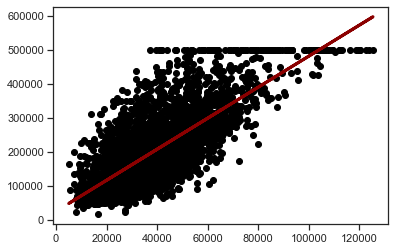

In [255]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot with matplotlib
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred_test, color='darkred', linewidth=3);

Same as for the previous plots: Due to the huge amount of data, I do not know if these distribution around the prediction is normal or if the data points need to be closer to the line

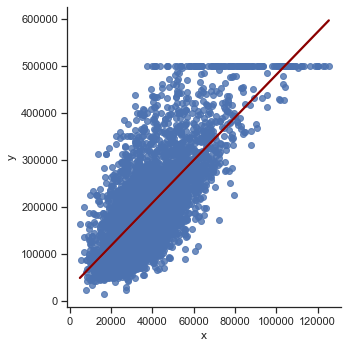

In [256]:
import seaborn as sns 
sns.set_theme(style="ticks")

# Plot with Seaborn

# We first need to create a DataFrame
df_test = pd.DataFrame({'x': X_test['median_income'], 'y':y_test})

sns.lmplot(x='x', y='y', data=df_test, line_kws={'color': 'darkred'}, ci=False);

Same as for the previous plots: Due to the huge amount of data, I do not know if these distribution around the prediction is normal or if the data points need to be closer to the line

## Model 3
This model includes the results from the feature selection (I will only use 2 features). SO this model will contain the median_income as well as the Ocean_proximity


This time I will add the ocean_proximity instead of the dummy variables (as I did on model 1). To test my preprocessor pipeline

In [257]:
# Select features for the simple regression
features = ['median_income', 'ocean_proximity']

X = df[features]

# Create response
y = df['median_house_value']

In [258]:
# check feature
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   median_income    19579 non-null  float64 
 1   ocean_proximity  19579 non-null  category
dtypes: category(1), float64(1)
memory usage: 841.3 KB


In [259]:
# check for missing values
# There wont be any missing values due to the fact that I cleaned up the data manually, normally the data preprocessor would take care of this
print("Missing values X:",X.isnull().any(axis=1).sum())

print("Missing values Y:",y.isnull().sum())

Missing values X: 0
Missing values Y: 0


### Data Split

In [260]:
from sklearn.model_selection import train_test_split
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Modeling


In [261]:
from sklearn.linear_model import LinearRegression

# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

In [262]:
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000293B729D5E0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000293B729DCD0>)])),
                ('lm', LinearRegression())])

### Evaluation with training data

In [263]:
X_train.head()

median_income ocean_proximity
14041        24167.0      NEAR OCEAN
19164        32857.0       <1H OCEAN
19710        34426.0          INLAND
5462         25938.0       <1H OCEAN
7486         30417.0       <1H OCEAN

In [264]:
y_pred = lm_pipe.predict(X_train)

y_pred

array([177508.3549879 , 195314.6784731 , 134111.30236933, ...,
       149210.81262225, 209124.75543273, 278223.77202981])

In [265]:
# R squared
print('R squared is:',r2_score(y_train, y_pred))  
# MSE
print('MSE is:', mean_squared_error(y_train, y_pred))
#RMSE
print('RMSE is:' ,mean_squared_error(y_train, y_pred, squared=False))

R squared is: 0.6593612136580634
MSE is: 3967208806.7555656
RMSE is: 62985.78257635262


R2 increased and RMSE decreased. But if more variables are added to the model then the R2 increases and also the RMSE decreases.

RMSE value os model 1 is the lowest, therefore model 1 is superior



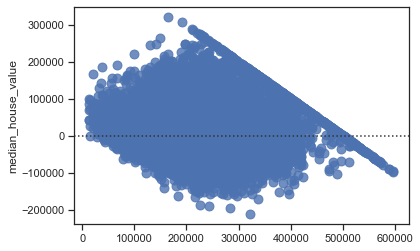

In [266]:
sns.residplot(x=y_pred, y=y_train, scatter_kws={"s": 80});

Same as for the previous plots: Due to the huge amount of data, I do not know if these distribution around the prediction is normal or if the data points need to be closer to the line. But is looks like an  improvement

### Evaluation with test data

In [267]:
y_pred_test = lm_pipe.predict(X_test)

In [268]:
# R2 score
print("R2-Score of the model is:", r2_score(y_test, y_pred_test) )
# MSE
print('Mean squared error of the model is:', mean_squared_error(y_test, y_pred_test))
#RMSE
print('RMSE of the model is:', mean_squared_error(y_test, y_pred_test, squared=False))



R2-Score of the model is: 0.6627843187126965
Mean squared error of the model is: 3913776574.598218
RMSE of the model is: 62560.18362024058


The values are similar to those from the training data

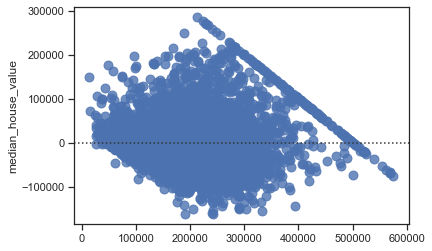

In [269]:
sns.residplot(x=y_pred_test, y=y_test, scatter_kws={"s": 80});

## Lasso regression


### Create dummy variables

In [270]:
# change the column Ocean Proximity to dummy variables
dummies = pd.get_dummies(df[['ocean_proximity']])

In [271]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ocean_proximity_<1H OCEAN   19579 non-null  uint8
 1   ocean_proximity_INLAND      19579 non-null  uint8
 2   ocean_proximity_ISLAND      19579 non-null  uint8
 3   ocean_proximity_NEAR BAY    19579 non-null  uint8
 4   ocean_proximity_NEAR OCEAN  19579 non-null  uint8
dtypes: uint8(5)
memory usage: 764.6 KB


In [272]:
print(dummies.head)

<bound method NDFrame.head of        ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
20635                          0                       1   
20636                          0                       1   
20637                          0                       1   
20638                          0                       1   
20639                          0                       1   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
0                           0                         1   
1                           0                         1   
2                           0                         1   
3            

## Model 1

### Create features

This model will include all variables.

In [273]:
# drop median house value (as it is will be included in y and drop ocean_proximity as it will be added via the dummy variables)
X_numerical = df.drop(['median_house_value', 'ocean_proximity'], axis=1).astype('float64')


In [274]:
list_numerical = X_numerical.columns
list_numerical

Index(['median_housing_age', 'population', 'households', 'median_income',
       'avg_rooms_per_household', 'avg_size_per_household'],
      dtype='object')

In [275]:
# create label
y = df['median_house_value']

#create feature --> all columns except the median_house_value and ocean proximity, plus add the dummy variables
X = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

# create a list of feature names
feature_names = X.columns

In [276]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_housing_age          19579 non-null  float64
 1   population                  19579 non-null  float64
 2   households                  19579 non-null  float64
 3   median_income               19579 non-null  float64
 4   avg_rooms_per_household     19579 non-null  float64
 5   avg_size_per_household      19579 non-null  float64
 6   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 7   ocean_proximity_INLAND      19579 non-null  uint8  
 8   ocean_proximity_ISLAND      19579 non-null  uint8  
 9   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 10  ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(6), uint8(5)
memory usage: 1.6 MB


## Data split

In [277]:
from sklearn.model_selection import train_test_split
# Train Test Split
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [278]:
X_train.head()

median_housing_age  population  households  median_income  \
14041                27.0       880.0       400.0        24167.0   
19164                16.0       880.0       327.0        32857.0   
19710                22.0      1200.0       370.0        34426.0   
5462                 41.0       833.0       270.0        25938.0   
7486                 35.0      1870.0       412.0        30417.0   

       avg_rooms_per_household  avg_size_per_household  \
14041                     3.88                    2.20   
19164                     5.15                    2.69   
19710                     5.79                    3.24   
5462                      4.24                    3.09   
7486                      4.05                    4.54   

       ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
14041                          0                       0   
19164                          1                       0   
19710                          0                       1   
5462                           1                       0   
7486                           1                       0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
14041                       0                         0   
19164                       0                         0   
19710                       0                         0   
5462                        0                         0   
7486                        0                         0   

       ocean_proximity_NEAR OCEAN  
14041                           1  
19164                           0  
19710                           0  
5462                            0  
7486                            0

## Standardization

To avoid data leakage, the standardization of numerical features should always be performed after data splitting and only from training data. Furthermore, we obtain all necessary statistics for our features (mean and standard deviation) from training data and also use them on test data. Note that we don’t standardize our dummy variables (which only have values of 0 or 1).

In [279]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train = scaler.transform(X_train[list_numerical])
X_test = scaler.transform(X_test[list_numerical])

In [280]:
X_train

array([[-0.13230718, -0.52459596, -0.25143301, -0.79327963, -0.92596783,
        -0.7839558 ],
       [-1.02196102, -0.52459596, -0.47448543, -0.30120668, -0.13454092,
        -0.26900001],
       [-0.53669529, -0.19110977, -0.34309839, -0.21236175,  0.26428839,
         0.30901158],
       ...,
       [-1.91161487,  1.64827502,  2.01270185, -0.0041509 ,  0.13965424,
        -0.36358373],
       [ 0.59559142, -0.0368724 , -0.5142071 , -0.11077615, -0.24671166,
         1.41248826],
       [-0.45581767,  0.84790815,  1.21521305,  0.59550992,  0.67558112,
        -0.46867674]])

## Lasso Regression

### Testing with random selected alpha of 1

In [281]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

### Model evaluation

In [282]:
print('R squared training set is:', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set is:', round(reg.score(X_test, y_test)*100, 2))

R squared training set is: 65.67
R squared test set is: 65.57


In [283]:
from sklearn.metrics import mean_squared_error

#Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set is:', round(mse_train,2))

# Test data
pred =reg.predict(X_test)
mse_test = mean_squared_error(y_test, pred)
print('MSE test set is:', round(mse_test,2))

MSE training set is: 3998556787.78
MSE test set is: 3996055962.81


Similar values for the trainig and test set

### Lasso with optimal alpha (k-fold cross validation)

In [284]:
from sklearn.linear_model import LassoCV


# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model

model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

Show best value of penalization chosen by cross validation:

In [285]:
print('The optimal alpha values is:', model.alpha_)

The optimal alpha values is: 80.76540562168341


### Best model

In [286]:
# set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=80.76540562168341)

Show the Model coefficents and names

In [287]:
print(list(zip(lasso_best.coef_, X)))

[(22794.669865190146, 'median_housing_age'), (-38782.4040190795, 'population'), (46299.00306593746, 'households'), (89139.59439492601, 'median_income'), (-12303.021465185091, 'avg_rooms_per_household'), (-5803.798311276273, 'avg_size_per_household')]


### Model evaluation

In [288]:
print('R squared training set is:', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set is:', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set is: 65.66
R squared test set is: 65.57


Only minor difference between Training set and Test set. 

But there is no difference between the random selected alpha of 1 and the optimal alpha of 80.76...

In [289]:
print('MSE of the training set is:', mean_squared_error(y_train, lasso_best.predict(X_train)))
print('MSE of the test set is:', mean_squared_error(y_test, lasso_best.predict(X_test)))

MSE of the training set is: 3998821673.0698667
MSE of the test set is: 3995490066.1752934


Only minor difference between Training set and Test set. 

But there is no difference between the random selected alpha of 1 and the optimal alpha of 80.76...
 
Lasso path: plot results of cross-validation with mean squared erros

(57.1775284339457, 114084.16774731352, 3486944047.4520907, 12323778251.856926)

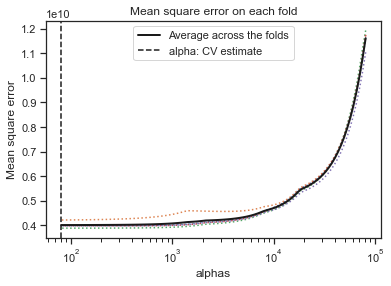

In [290]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

# ymin, ymax = 3800000000, 4500000000
# plt.ylim(ymin, ymax);

## Model 2

### Create features

This model will only include the features from the feature selection (I will only use 2)

In [291]:
# X_numerical = df['median_income'] --> it is not working this way, probably because only the values and not the column will be added

X_numerical = df.drop(['median_house_value', 'ocean_proximity', 'median_housing_age', 'population', 'households', 'avg_rooms_per_household', 'avg_size_per_household'], axis=1).astype('float64')


X_numerical

median_income
0            83252.0
1            83014.0
2            72574.0
3            56431.0
4            38462.0
...              ...
20635        15603.0
20636        25568.0
20637        17000.0
20638        18672.0
20639        23886.0

[19579 rows x 1 columns]

In [292]:
list_numerical = X_numerical.columns
list_numerical

Index(['median_income'], dtype='object')

In [293]:
# create label
y = df['median_house_value']

#create feature --> all columns except the median_house_value and ocean proximity, plus add the dummy variables
X = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

# create a list of feature names
feature_names = X.columns

In [294]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_income               19579 non-null  float64
 1   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 2   ocean_proximity_INLAND      19579 non-null  uint8  
 3   ocean_proximity_ISLAND      19579 non-null  uint8  
 4   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 5   ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(1), uint8(5)
memory usage: 917.6 KB


## Data Split

In [295]:
from sklearn.model_selection import train_test_split
# Train Test Split
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [296]:
X_train.head()

median_income  ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
14041        24167.0                          0                       0   
19164        32857.0                          1                       0   
19710        34426.0                          0                       1   
5462         25938.0                          1                       0   
7486         30417.0                          1                       0   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
14041                       0                         0   
19164                       0                         0   
19710                       0                         0   
5462                        0                         0   
7486                        0                         0   

       ocean_proximity_NEAR OCEAN  
14041                           1  
19164                           0  
19710                           0  
5462                            0  
7486                            0

## Standardization

In [297]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train = scaler.transform(X_train[list_numerical])
X_test = scaler.transform(X_test[list_numerical])

In [ ]:
X_train

array([[-0.79327963],
       [-0.30120668],
       [-0.21236175],
       ...,
       [-0.0041509 ],
       [-0.11077615],
       [ 0.59550992]])

## Lasso Regression

### Testing with random selected alpha of 1

In [298]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

### Model evaluation

In [299]:
print('R squared training set is:', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set is:', round(reg.score(X_test, y_test)*100, 2))

R squared training set is: 56.01
R squared test set is: 55.67


In [300]:
#Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set is:', round(mse_train,2))

# Test data
pred =reg.predict(X_test)
mse_test = mean_squared_error(y_test, pred)
print('MSE test set is:', round(mse_test,2))

MSE training set is: 5123329426.85
MSE test set is: 5145540144.67


Similar values for the training and test set

### Lasso with optimal alpha (k-fold cross validation)

In [301]:
from sklearn.linear_model import LassoCV


# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model

model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

Show best value of penalization chosen by cross validation:

In [302]:
print('The optimal alpha values is:', model.alpha_)

The optimal alpha values is: 80.76540562168346


Similar alpha, now lets have a look on our data when we use this alpha value for the Model 2

### Best model

In [303]:
# set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=80.76540562168346)

In [304]:
print(list(zip(lasso_best.coef_, X)))

[(80684.64021606176, 'median_income')]


### Model evaluation

In [305]:
print('R squared training set is:', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set is:', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set is: 56.01
R squared test set is: 55.67


In [306]:
print('MSE of the training set is:', mean_squared_error(y_train, lasso_best.predict(X_train)))
print('MSE of the test set is:', mean_squared_error(y_test, lasso_best.predict(X_test)))

MSE of the training set is: 5123335948.901793
MSE of the test set is: 5145475170.792929


Again no difference between the random alpha of 1 and the best alpha...
As the model was adapted (only with the selected features from feature selection), I do not know what is wrong with my model ...

# Splines
### Create label and feature

Due to the fact that the median_income has the biggest effect on the median_house_value (see correlation analysis) and the model with only median_income has the highest F-Statistic, I will only use this feature to predict the median_house_value

Beside the Natural Spline Regression I will also do the Ridge Regression, the Polynomial regression as well as the splines in patsy and scikit learn

In [307]:
X = df[['median_income']]
y = df[['median_house_value']]

### Data split
Dividing data intro train and test datasets

In [308]:
# Train Test Split
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

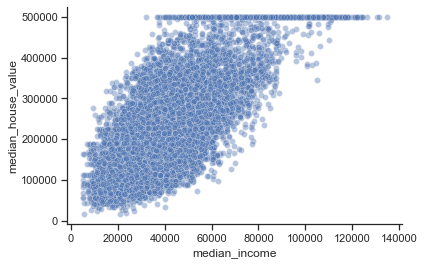

In [309]:
# seaborn settings
costum_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=costum_params)

#plot
sns.scatterplot(x=X_train['median_income'], y=y_train['median_house_value'], alpha=0.4)

## Ridge Regression

In [310]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)

Ridge()

In [311]:
print(reg.coef_)
print(reg.intercept_)

[[4.57335693]]
[24349.5332512]


In [312]:
from sklearn.metrics import mean_squared_error

# create function to obtain model mse
def model_results(model_name):

    # Training data
    pred_train = reg.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, pred_train, squared=False),4)

    # Test data
    pred_test = reg.predict(X_test)
    rmse_test = round(mean_squared_error(y_test, pred_test, squared=False),4)

    # Print model results
    result = pd.DataFrame(
        {"model": model_name,
        "rmse_train": [rmse_train],
        "rmse_test": [rmse_test]}
    )

    return result

In [313]:
model_results(model_name="ridge")

model  rmse_train   rmse_test
0  ridge  71577.4366  71732.4267

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

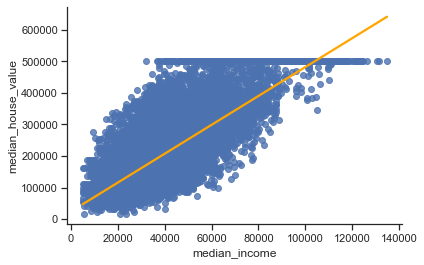

In [314]:
sns.regplot(x=X_train['median_income'],
            y=y_train['median_house_value'],
            ci=None,
            line_kws={"color": "orange"})

## Polynomial regression
This will be used to add non linear features to the Ridge-Regression model

In [315]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# use polynomial features with degree 1
reg = make_pipeline(PolynomialFeatures(degree=2),
                        Ridge())

reg.fit(X_train, y_train)

C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.97756e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge())])

In [316]:
model_results(model_name="poly")

model  rmse_train   rmse_test
0  poly  71564.2587  71702.9094

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

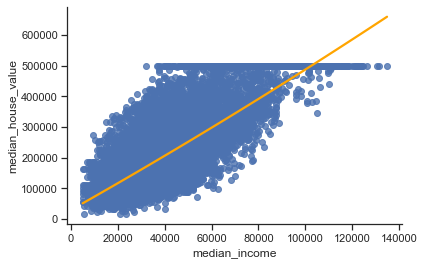

In [317]:
# plot 
sns.regplot(x=X_train['median_income'],
                y=y_train['median_house_value'],
                ci=None,
                order=2,
                line_kws={"color": "orange"})

## Splines
### Splines in Scikit learn

In [318]:
from sklearn.preprocessing import SplineTransformer

# use a spline wit 4 knots and 1 degree with a ridge regressions
reg = make_pipeline(SplineTransformer(n_knots=4, degree=2), 
                       Ridge(alpha=1))
                     
reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)

In [319]:
model_results(model_name = "spline")

model  rmse_train   rmse_test
0  spline  71269.8689  71328.0719

C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SplineTransformer was fitted with feature names
  warnings.warn(


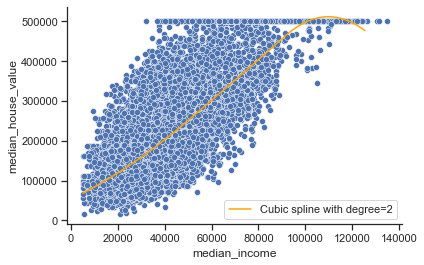

In [320]:
# Create observations
x_new = np.linspace(X_test.min(), X_test.max(),100)
#Make some oredictions
pred= reg.predict(x_new)

#plot
sns.scatterplot(x=X_train['median_income'], y=y_train['median_house_value'])

plt.plot(x_new, pred, label='Cubic spline with degree=2', color='orange')
plt.legend()

### Splines in patsy
In the next step I use the module patsy to create non-linear tranformations of the input data.
Moreover statsmodels is used to fit 2 models with different number of knots

In [321]:
from patsy import dmatrix
# Generating cubic spines with 3 knots at 25000, 40000 and 60000
transformed_x = dmatrix(
    "bs(train, knots=(25000,40000,60000), degree=2, include_intercept=False)",
    {"train": X_train}, return_type='dataframe'
)

Statsmodels is used for estimating a generalized linear model:

In [322]:
# Fitting gneralised linear model on transformed dataset
reg = sm.GLM(y_train, transformed_x).fit()

In [323]:
#Training data
pred_train = reg.predict(dmatrix("bs(train, knots=(25000,40000,60000), include_intercept=False)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

# Test data
pred_test = reg.predict(dmatrix("bs(test, knots=(25000,40000,60000), include_intercept=False)", {"test": X_test}, return_type='dataframe'))
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results = pd.DataFrame(
    {
        "model": "Cubic spline (cs)",
        "rmse_train": [rmse_train],
        "rmse_test": [rmse_test]
    })

model_results

ValueError: shapes (15663,7) and (6,) not aligned: 7 (dim 1) != 6 (dim 0)

In [ ]:
# Create observations
xp = np.linspace(X_test.min(),X_test.max(),100)
# Make some predictions
pred = reg.predict(dmatrix("bs(xp, knots=(25000,40000,60000), include_intercept=False)", {"xp": xp}, return_type='dataframe'))

# plot
sns.scatterplot(x=X_train['median_income'], y=y_train['median_house_value'])

plt.plot(xp, pred, label='Cubuc spline with degree=3 (3 knots)', color='orange')
plt.legend()

ValueError: shapes (100,7) and (6,) not aligned: 7 (dim 1) != 6 (dim 0)

### Natural spline
Now a natural spline will be fitted with patsy and stats models

In [ ]:
transformed_x3 = dmatrix("cr(train, df=2)", {"train": X_train}, return_type='dataframe')

reg = sm.GLM(y_train, transformed_x3).fit()

C:\Users\Daniel\anaconda3\lib\site-packages\patsy\mgcv_cubic_splines.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  banded_b = np.array([np.r_[0., ul_diag], diag, np.r_[ul_diag, 0.]])


PatsyError: Error evaluating factor: ValueError: object arrays are not supported
    cr(train, df=2)
    ^^^^^^^^^^^^^^^

In [ ]:
# Training data
pred_train = reg.predict(dmatrix("cr(train, df=3)", {"train": X_train}, return_type='dataframe'))
rmse_train = mean_squared_error(y_train, pred_train, squared=False)

#Test data
pred_test = reg.predict(dmatrix("cr(test, df=4)", {"test": X_test}, return_type='dataframe'))
rmse_test = mean_squared_error(y_test, pred_test, squared=False)

# Save model results
model_results_ns = pd.DataFrame(
    {"model": "natural splines (ns)",
    "rmse_train": [rmse_train],
    "rmse_test": [rmse_test]})

model_results_ns

model    rmse_train     rmse_test
0  natural splines (ns)  71473.160613  72566.779667

In [ ]:
# Make predictions
pred = reg.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

#plot
sns.scatterplot(x=X_train['median_income'], y=y_train['median_house_value'])
plt.plot(xp, pred, color='orange', label='Natural spline with df=3')
plt.legend()

ValueError: shapes (100,4) and (5,) not aligned: 4 (dim 1) != 5 (dim 0)

# Feature selection

Feature selection will be made with the Filter method and the wrapper method. For the wrapper method the forward selection will be made for sure and the backward selection depends on the time it needs to get the results

## Prepare Data


In [324]:
X_numerical = df.drop(['median_house_value', 'ocean_proximity'], axis=1).astype('float64')

X_numerical


median_housing_age  population  households  median_income  \
0                    41.0       322.0       126.0        83252.0   
1                    21.0      2401.0      1138.0        83014.0   
2                    52.0       496.0       177.0        72574.0   
3                    52.0       558.0       219.0        56431.0   
4                    52.0       565.0       259.0        38462.0   
...                   ...         ...         ...            ...   
20635                25.0       845.0       330.0        15603.0   
20636                18.0       356.0       114.0        25568.0   
20637                17.0      1007.0       433.0        17000.0   
20638                18.0       741.0       349.0        18672.0   
20639                16.0      1387.0       530.0        23886.0   

       avg_rooms_per_household  avg_size_per_household  
0                         6.98                    2.56  
1                         6.24                    2.11  
2                         8.29                    2.80  
3                         5.82                    2.55  
4                         6.28                    2.18  
...                        ...                     ...  
20635                     5.05                    2.56  
20636                     6.11                    3.12  
20637                     5.21                    2.33  
20638                     5.33                    2.12  
20639                     5.25                    2.62  

[19579 rows x 6 columns]

## Create label and features

In [325]:
# create label
y = df['median_house_value']

#create features
X = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

#create list of feature names
feature_names = X.columns




## Data Split

In [326]:
# Train Test Split
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [327]:
# make list of numerical features (Ocean proximity values are categorical)
list_numerical = X.drop(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'], axis=1).columns

# standardize numerical features
scaler = StandardScaler().fit(X_train[list_numerical]) 
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

## Model
Best regularization parameter will be chosed based on the mean-squared error with lasso regression(5-fold cross validation). Will this be the same result as for the Lasso Regression?

In [328]:
reg = LassoCV(cv=5, random_state=10, max_iter=10000).fit(X_train, y_train)
# show best alpha parameter
reg.alpha_

80.76540562168341

Step above was unnecessary as it was already made during the lasso regression


Show feature importance:

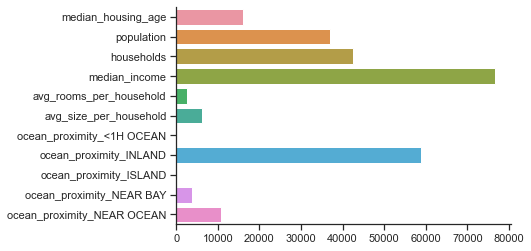

In [329]:
# get absolute values of coefficients
importance = np.abs(reg.coef_)

sns.barplot(x=importance, 
            y=feature_names);

## Feature selection
I would like to get 3 features selected. Therefore I will set the threshhold slightly above the coefficient of the fourth most important feature. 
Moreover I will record the time it needs to obtain the results

### Filter method

In [330]:
from sklearn.feature_selection import SelectFromModel
from time import time

# set threshold
threshold = np.sort(importance)[-4] + 1

# obtain time
tic = time()

# fit model
sfm = SelectFromModel(reg, threshold=threshold).fit(X_train, y_train)

# obtain time
toc = time()

# print results
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: Index(['households', 'median_income', 'ocean_proximity_INLAND'], dtype='object')
Done in 0.330s


### Wrapper method
#### Forward selection

In [331]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()

sfs_forward = SequentialFeatureSelector(
    reg, n_features_to_select=3, 
    direction="forward").fit(X_train, y_train)

toc_fwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Features selected by forward sequential selection: Index(['median_income', 'avg_size_per_household', 'ocean_proximity_INLAND'], dtype='object')
Done in 23.566s


#### Backward selection

In [332]:
tic_bwd = time()

sfs_backward = SequentialFeatureSelector(
    reg, n_features_to_select=3, 
    direction="backward").fit(X_train, y_train)

toc_bwd = time()

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by backward sequential selection: Index(['households', 'median_income', 'ocean_proximity_INLAND'], dtype='object')
Done in 62.339s


Conclusion: 2 Features were allways selected by the Feature selection:
- median_income
- ocean_proximity_INLAND

The third feature was selected two times: one time by the Backward selection and one time by the filter method: households
The forward selection selected the avg_size_per_household instead --> why? From the filter method I can see that this feature does not have a big influence on the median_house_value. Therefore I will focus on the features median_income and ocean_proximity_inland (--> ocean_proximity)

